# Graphyp on a sample of OpenEdition logs

Author : Patrice Bellot (patrice.bellot@univ-amu.fr)
First version : January 2021

## Analyse du fichier logs
Fichier mis en forme à partir des logs bruts.
Format CSV contenant id_session,num_step_in_session,id_visitor,url,id_url,datetime,dwell_time
Ex:
177909,1,15157181111194496757,rha.revues.org/6885,26795,2017-01-01 00:00:00,14.0
177919,1,17419670761580487651,jsa.revues.org/2772,63653,2017-01-01 00:00:33,327.0
177925,1,324768533961010976,inventaire-rra.hypotheses.org/3661,95865,2017-01-01 00:00:45,1092.0

In [31]:
import networkx as nx
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import random
import numpy as np
import math

In [109]:
#nom_fichier_log = "/Users/Patrice/Documents/Recherche/OpenEdition/ASO/Cometes/dwell_time_v4_2M.csv"
nom_fichier_log = "/Users/Patrice/Documents/Recherche/OpenEdition/ASO/Cometes/dwell_time_v4_10000.csv"
data = pd.read_csv(nom_fichier_log, dtype={'id_session':int, 'id_url':int})
data.shape

completeLogFile = "/Users/Patrice/Documents/Recherche/OpenEdition/ASO/Cometes/dwell_time_v4.csv"

# Découpage de fichier de logs en blocs de sessions (avec tailleBlocs lignes + lignes suivantes pour atteindre la fin d'une session)
#tailleBloc = 10000
tailleBloc = 10000
tailleLogs = len(data)
nbBlocs = tailleLogs//tailleBloc

ligne_en_cours = 0
blocs= []
numeroBloc = 1
while ligne_en_cours < tailleLogs:
    if tailleBloc*numeroBloc < tailleLogs:
        derniere_ligne = tailleBloc*numeroBloc
    else:
        derniere_ligne = tailleLogs
    blocEnCours = data.iloc[ligne_en_cours:derniere_ligne,]
    #continue until end of session :
    #display(blocEnCours)
    while derniere_ligne < tailleLogs and data['num_step_in_session'][derniere_ligne] != 1: #num_step_in_session == 1 = new session
        #blocEnCours = blocEnCours.append(data.iloc[derniere_ligne], ignore_index=True)
        blocEnCours = pd.concat([blocEnCours, pd.DataFrame([data.iloc[derniere_ligne,:]])])
        #print ("ligne ajoutée : ", pd.DataFrame([data.iloc[derniere_ligne,:]]))
        derniere_ligne += 1
    #print ("bloc ", numeroBloc, " en cours : ")
    #display(blocEnCours)
    blocs.append(blocEnCours)
    ligne_en_cours = derniere_ligne
    numeroBloc += 1
print("nombre de blocs : ", len(blocs))

#print("DATA : ", data)
#print("BLOCS : ", blocs[5])

nombre de blocs :  1


## Statistiques générales sur les logs utilisés

longueur des sessions :  id_session
177909    1
177919    1
177925    1
177938    1
177942    9
         ..
195942    2
195945    1
195959    1
195963    1
195967    4
Name: num_step_in_session, Length: 3533, dtype: int64
count    3533.000000
mean        2.830173
std         6.790509
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       248.000000
Name: num_step_in_session, dtype: float64
number of sessions :  3533


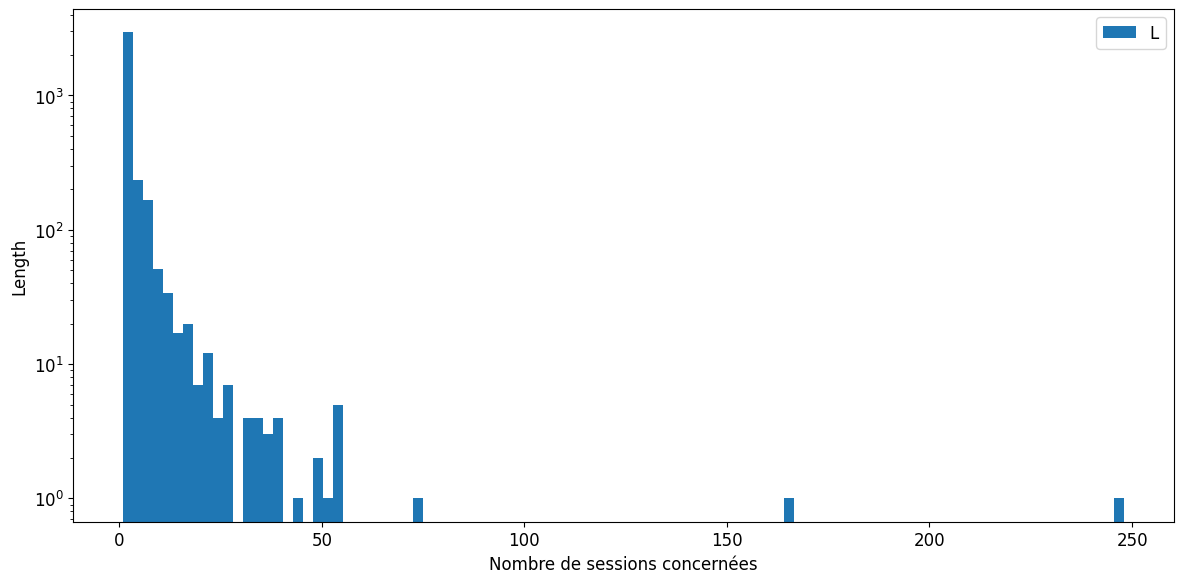

In [110]:
sessions = data.groupby('id_session').max()
print ("longueur des sessions : ", sessions['num_step_in_session'])
print (sessions['num_step_in_session'].describe())
print ("number of sessions : ", len(sessions))
plt.figure(figsize=(12,6))
plt.xlabel("Nombre de sessions concernées")
plt.ylabel("Length")
plt.hist(sessions['num_step_in_session'], bins=100, log=True)
plt.legend("Longueur des sessions en nombre de pages consultées")

In [111]:
compte_urls = Counter(data['id_url'])
print("The most frequents URls are: ", compte_urls.most_common(10))
print("Number of different URLs: ", len(compte_urls))
URL_counts = sorted(compte_urls.values(), reverse=True)

The most frequents URls are:  [(42063, 128), (224690, 37), (124630, 32), (576, 31), (224874, 31), (42777, 29), (113894, 26), (196270, 25), (73888, 22), (220080, 22)]
Number of different URLs:  6288


[31882, 13422, 8905, 8240, 8075, 3274, 2791, 2344, 2220, 1986, 1956, 1943, 1671, 1609, 1435, 1308, 1306, 1293, 1275, 1258, 1232, 1230, 1204, 1188, 1155, 1148, 1115, 1106, 1083, 1079, 1054, 1021, 975, 959, 956, 954, 866, 863, 861, 847, 842, 836, 813, 794, 792, 780, 771, 746, 704, 701, 698, 695, 689, 678, 676, 675, 675, 672, 665, 654, 652, 641, 636, 632, 630, 627, 625, 610, 609, 608, 605, 602, 601, 591, 590, 589, 578, 573, 571, 565, 564, 563, 560, 558, 548, 545, 545, 537, 535, 535, 532, 530, 522, 521, 518, 517, 516, 505, 504, 500, 496, 493, 489, 488, 487, 486, 481, 479, 470, 469, 467, 463, 461, 461, 459, 458, 451, 449, 448, 447, 445, 442, 441, 439, 436, 435, 432, 427, 424, 424, 423, 421, 418, 418, 417, 415, 414, 414, 414, 414, 408, 405, 400, 397, 396, 395, 394, 391, 385, 383, 383, 383, 381, 381, 380, 377, 373, 373, 371, 370, 369, 369, 369, 368, 368, 367, 366, 366, 364, 364, 363, 362, 359, 359, 357, 355, 355, 353, 353, 352, 352, 351, 350, 350, 348, 347, 346, 346, 346, 344, 343, 340, 340, 

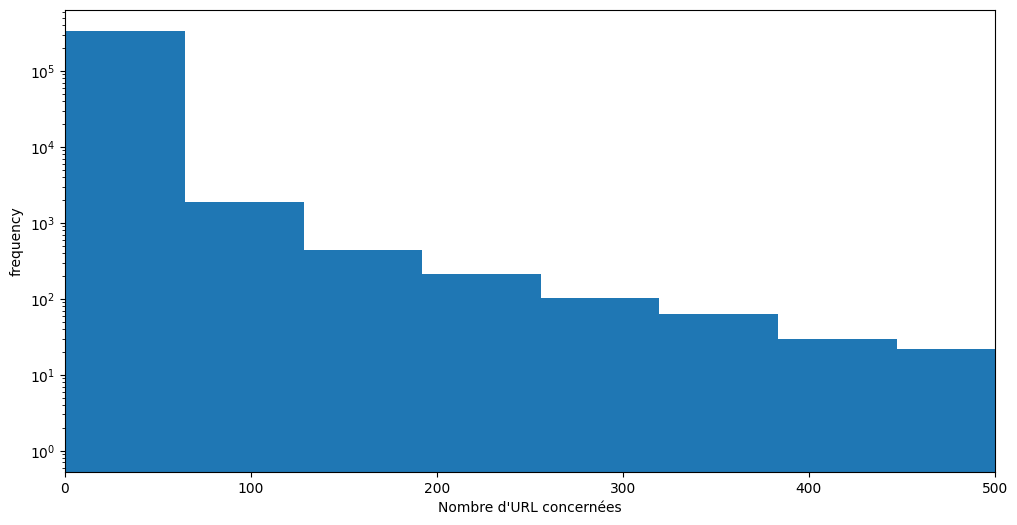

In [8]:
print(URL_counts)
plt.figure(figsize=(12,6))
plt.xlim(0,500)
plt.xlabel("Nombre d'URL concernées")
plt.ylabel('frequency')
g = plt.hist(URL_counts, bins=500, log=True)

## Construction de Graphyp
### Construction d'un graphe des sessions et estimation de N
Le poids des noeuds correspond au nombre de fois que l'URL a été consultée, ce nombre estime N.
Pour une session donnée, on peut voir l'évolution de N.
N devrait être estimé au fur et à mesure du fichier log pour refléter le N réel au moment où l'utilisateur a consulté le document.
Cela pose un problème de démarrage à froid : les logs ne sont pas complets, ils ne partent pas à t0 du site Web.
En conséquence, on peut estimer, si les logs concernent une courte période, qu'il vaut mieux estimer les N a posteriori (à la fin de la construction du graphe).
Ils reflètent donc les valeurs de N non pas au moment de la recherche mais à la date de fin des logs analysés.

The weight of the nodes corresponds to the number of times the URL has been consulted, this number estimates N. For a given session, we can see the evolution of N. N should be estimated as the log file goes along to reflect the real N at the time the user consulted the document. This poses a problem of cold start: the logs are not complete, they do not leave at t0 from the Web site. As a consequence, if the logs concern a short period, it is better to estimate the N a posteriori (at the end of the graph construction). They thus reflect the values of N not at the time of the research but at the end of the analyzed logs.

In [112]:
graph = nx.Graph()
# parcours ligne à ligne du fichier log et création d'une arête (id_url_précédente, id_url) chaque fois que num_step est différent de 1 (session de longueur min = 2)
nombre_sessions_graphe = 0
for ind in data.index:
    url_lue = data['id_url'][ind]
    if data['num_step_in_session'][ind] == 2:
        nombre_sessions_graphe += 1
    if data['num_step_in_session'][ind] > 1:
        #print("ajout du lien ", url_precedente, " vers ", url_lue)
        if url_precedente not in graph:
            graph.add_node(url_precedente)
            graph.nodes[url_precedente]['nb'] = 1
            N_precedente = 1
            #print("ajout du noeud : ", url_precedente, " avec att : ", graph.nodes[url_precedente], graph.nodes[url_precedente]['nb'])
        else:
            weight = graph.nodes[url_precedente]['nb'] + 1
            graph.nodes[url_precedente]['nb'] = weight
            N_precedente = weight
        if url_lue not in graph:
            graph.add_node(url_lue)
            graph.nodes[url_lue]['nb'] = 1
            N_lue = 1
            #print("ajout du noeud : ", url_lue, " avec att : ", graph.nodes[url_lue], graph.nodes[url_lue]['nb'])
        else:
            weight = graph.nodes[url_lue]['nb'] + 1
            graph.nodes[url_lue]['nb'] = weight
            N_lue = weight
        graph.add_edge(url_precedente, url_lue)
    url_precedente = url_lue
#list(nx.connected_components(graph))
print ("nombre de noeuds : ", graph.number_of_nodes())
print ("nombre d'arêtes : ", graph.number_of_edges())
print ("nombre de sessions dans le graphe (longueur > 1) : ", nombre_sessions_graphe)

nombre de noeuds :  4704
nombre d'arêtes :  4550
nombre de sessions dans le graphe (longueur > 1) :  1532


/Users/Patrice/PycharmProjects/Graphyp/venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/Patrice/PycharmProjects/Graphyp/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


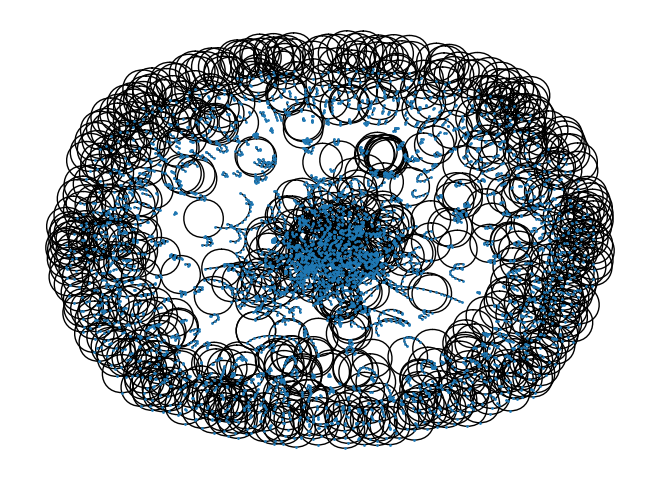

In [113]:
# Affichage du graphe
options = { 'node_size' : 1}
nx.draw(graph, **options)

In [12]:
def cm_to_inch(value):
    return value/2.54
plt.figure(figsize=(cm_to_inch(30),cm_to_inch(20)))
for ind in indice_N_sessions:
    if len(ind) >= 10 and len(ind) <= 50:
        plt.plot(ind)
        #print("longueur session : ", len(ind))
plt.xlabel("étape dans la session")
plt.ylabel("N")
plt.title("Evolution de N dans les sessions de longeur comprise entre 10 et 50")

plt.figure(figsize=(cm_to_inch(30),cm_to_inch(20)))
for ind in indice_K_sessions:
    if len(ind) >= 10 and len(ind) <= 50:
        plt.plot(ind)
        #print("longueur session : ", len(ind))
plt.xlabel("étape dans la session")
plt.ylabel("N")
plt.title("Evolution de K dans les sessions de longeur comprise entre 10 et 50")

# =======================================================================================
# =======================================================================================

NameError: name 'indice_N_sessions' is not defined

<Figure size 1181.1x787.402 with 0 Axes>

In [13]:
# Création d'un tableau à deux dimensions à partir des logs où chaque ligne correspond à une session d'un utilisateur
# Cette fonction est appelée pour chaque bloc de sessions
# Ligne : liste des articles consultés (URLs)
def creeTableauSessions(logs):
    nombre_session_logs = 0
    sessions = []
    for ind in logs.index:
        url_lue = logs['id_url'][ind]
        if data['num_step_in_session'][ind] == 1: # début d'une nouvelle session
            nombre_session_logs += 1
            ligne = [url_lue]
            sessions.append(ligne)
        if data['num_step_in_session'][ind] > 1: # on continue la session en cours
            #print("ajout du lien ", url_precedente, " vers ", url_lue)
            ligne.append(url_precedente)
        url_precedente = url_lue
    return sessions

# Estimation de N et K pour un bloc de sessions passé en paramètre en même temps que le numéro du bloc
# pour chaque session, K est déjà estimé : il s'agit du nombre d'articles lus dans la session :
def estimationNK(sessions, indiceBloc):
    global K
    for ind in sessions:
        K[indiceBloc].append(len(ind))
    #print(K)
    if indiceBloc < 50:
        fig, ax = plt.subplots(figsize=(12,5))
        plt.rcParams['font.size'] = '16'
        ax.plot(K[indiceBloc])
        ax.set_xlabel("Search Session Number", fontsize=16)
        ax.set_ylabel("K", fontsize=16)
        plt.show()

    KMean[indiceBloc] = np.mean(K[indiceBloc])
    #print("valeur moyenne de K : ", np.mean(K[indiceBloc]), " valeur max :", np.max(K[indiceBloc]), " nombre sessions : ", len(K[indiceBloc]) )
    #print("valeur médiane de K : ", np.median(K[indiceBloc]))

    global N
    N[indiceBloc] = np.zeros(np.max(K[indiceBloc])+1)
    for i in range(len(sessions)):
        N[indiceBloc][K[indiceBloc][i]] += 1

    NMean[indiceBloc] = np.mean(N[indiceBloc])
    #print("valeur moyenne de N : ", np.mean(N[indiceBloc]))

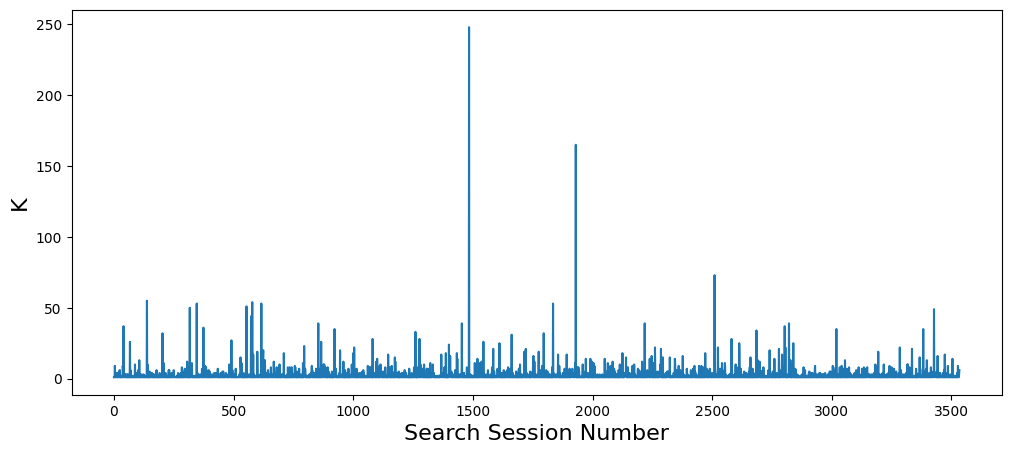

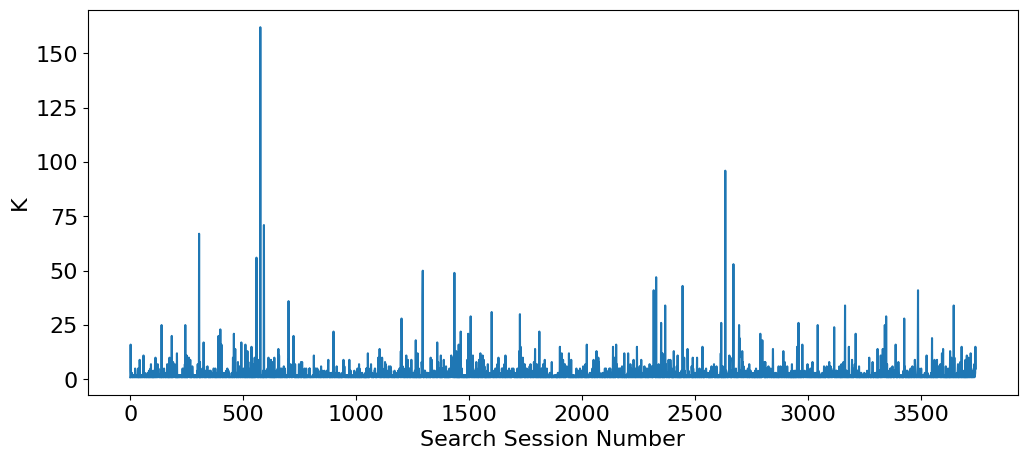

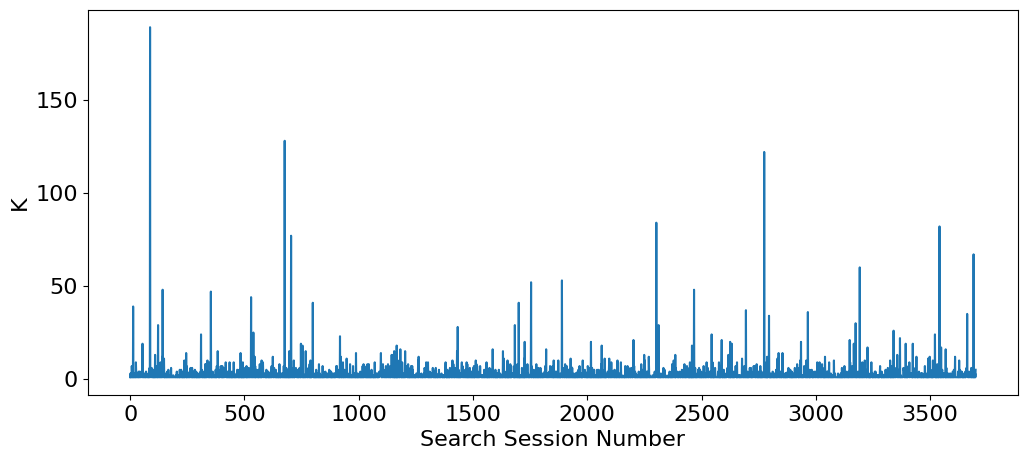

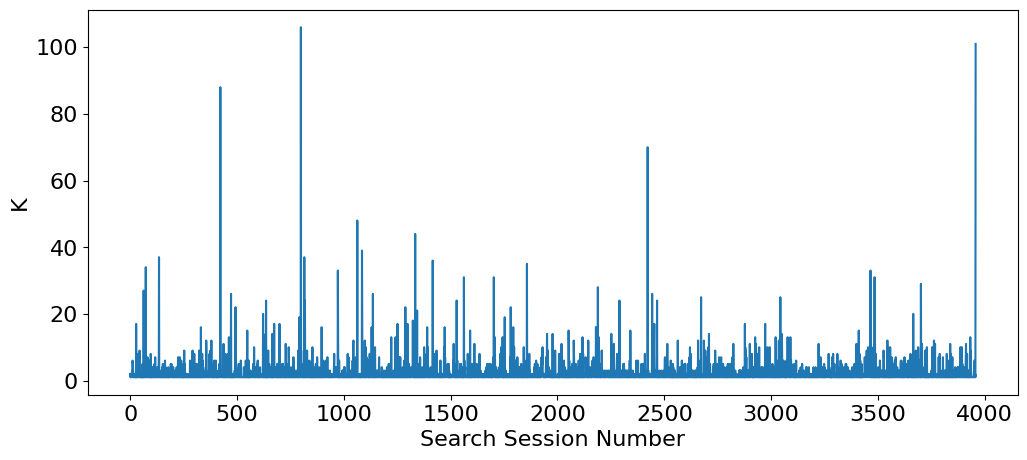

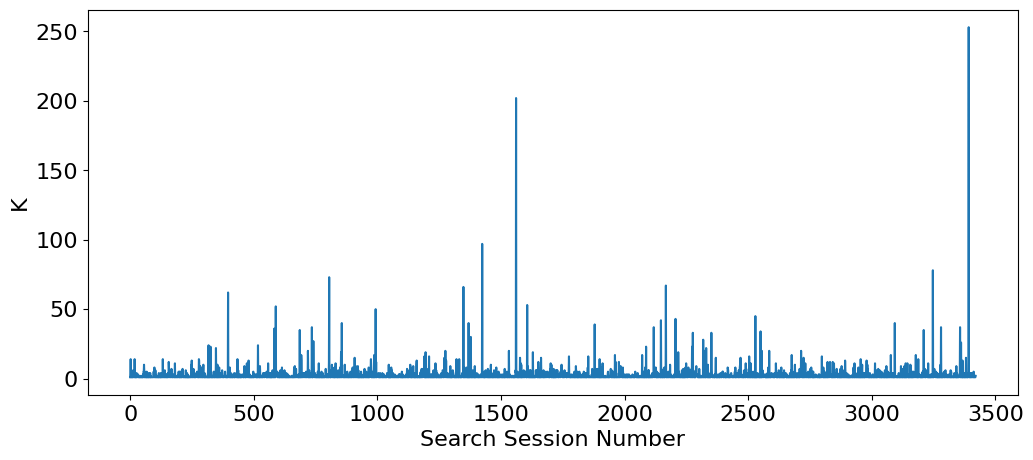

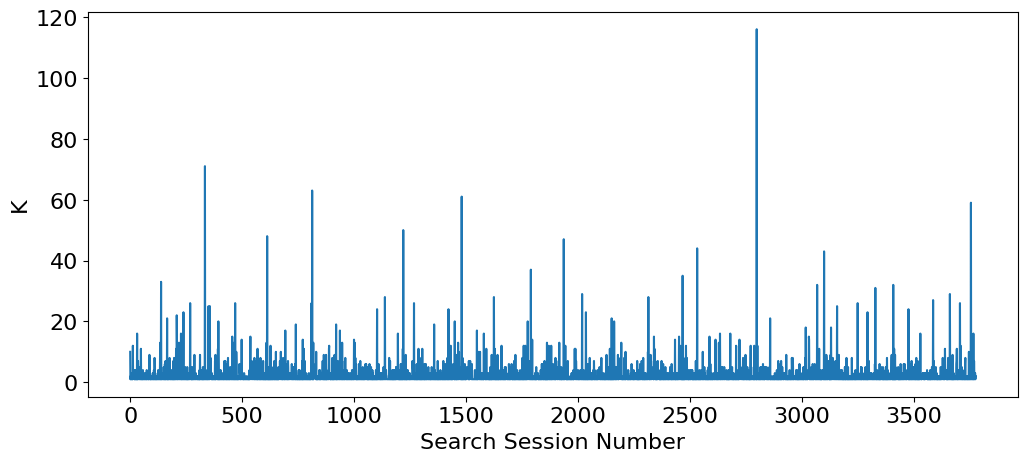

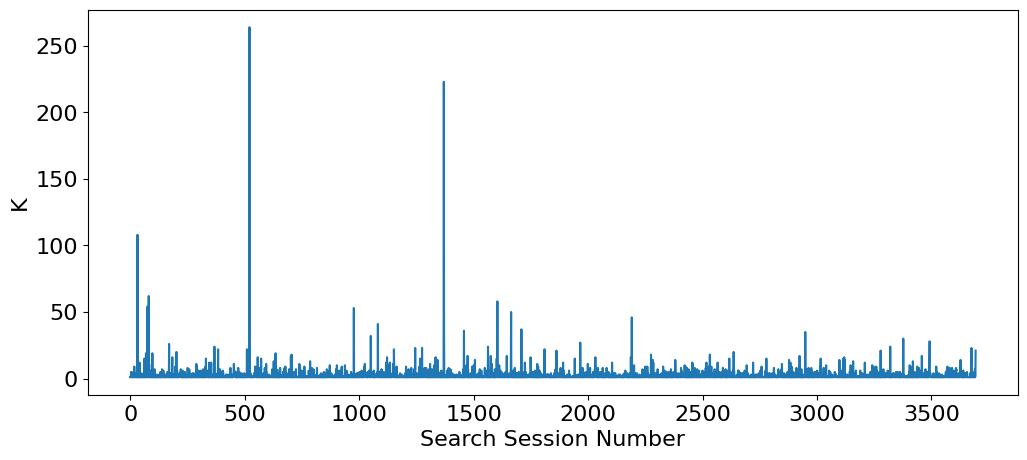

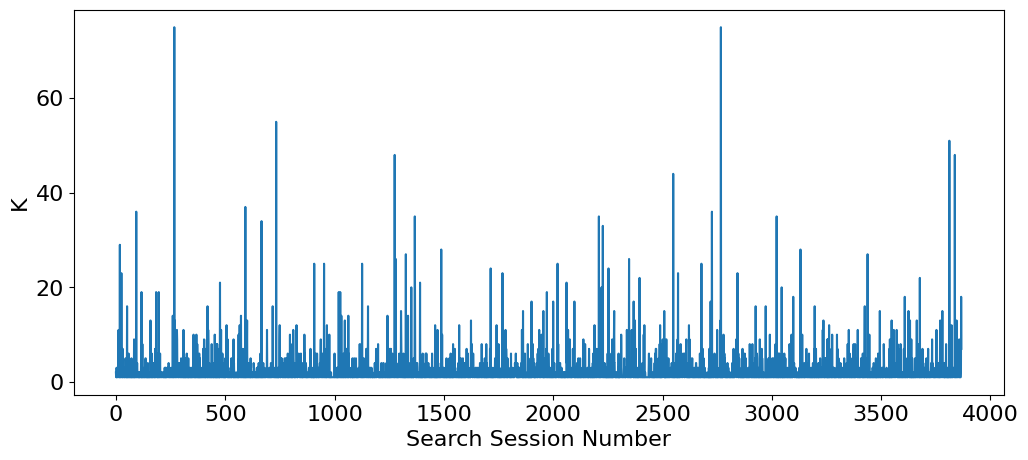

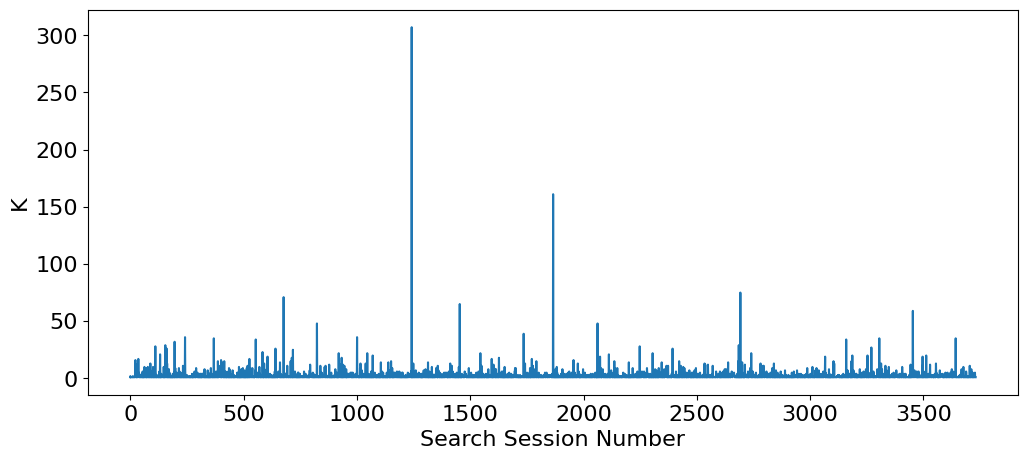

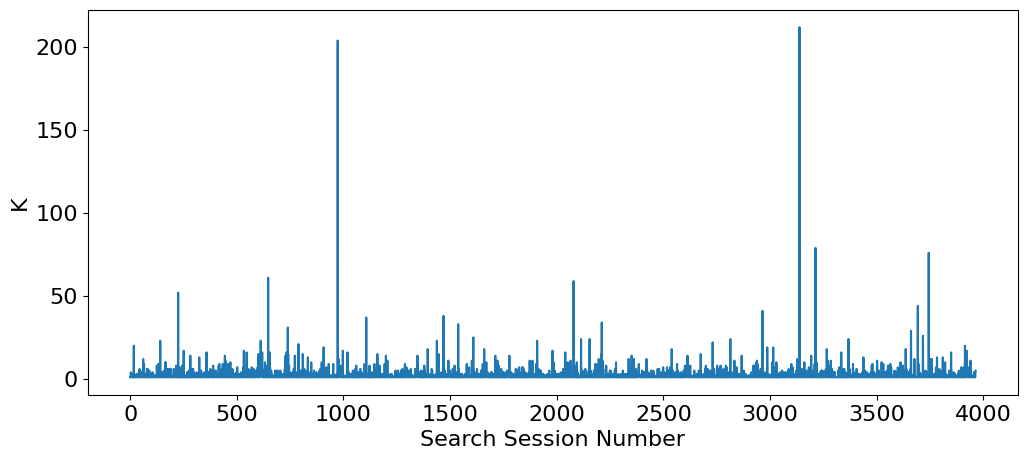

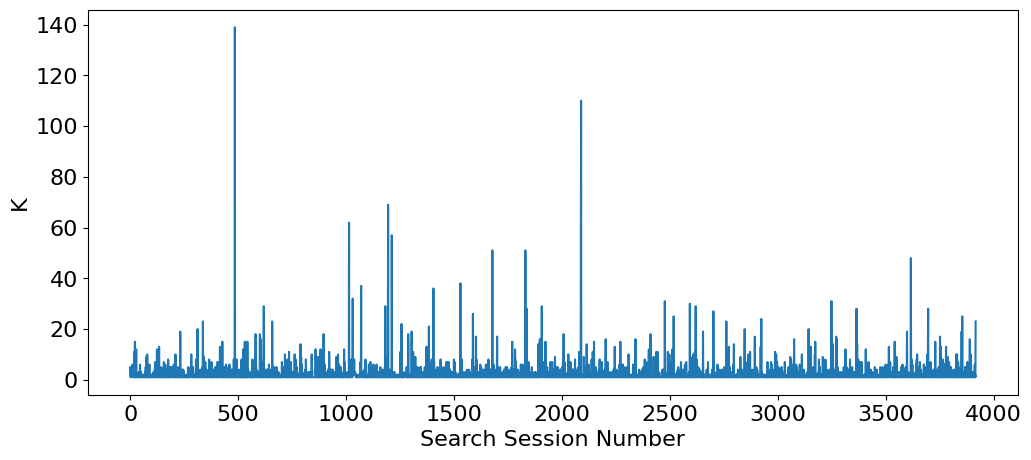

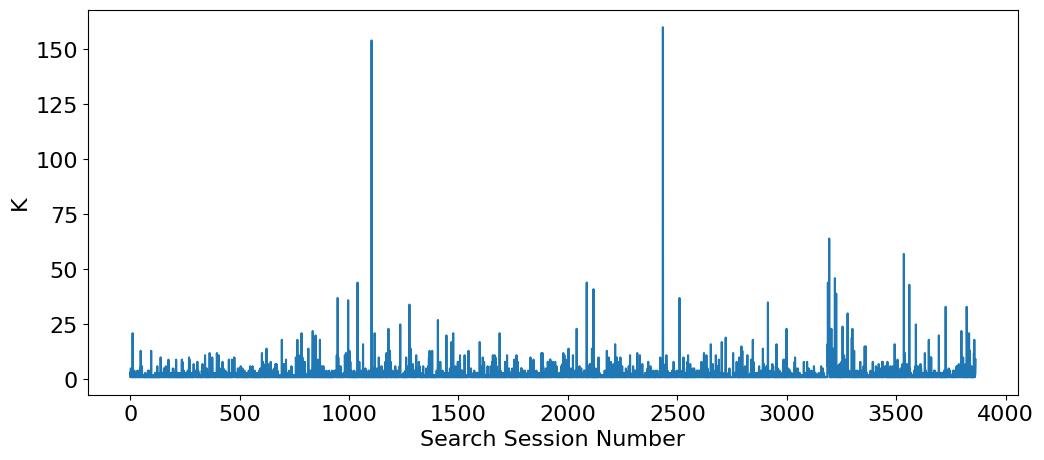

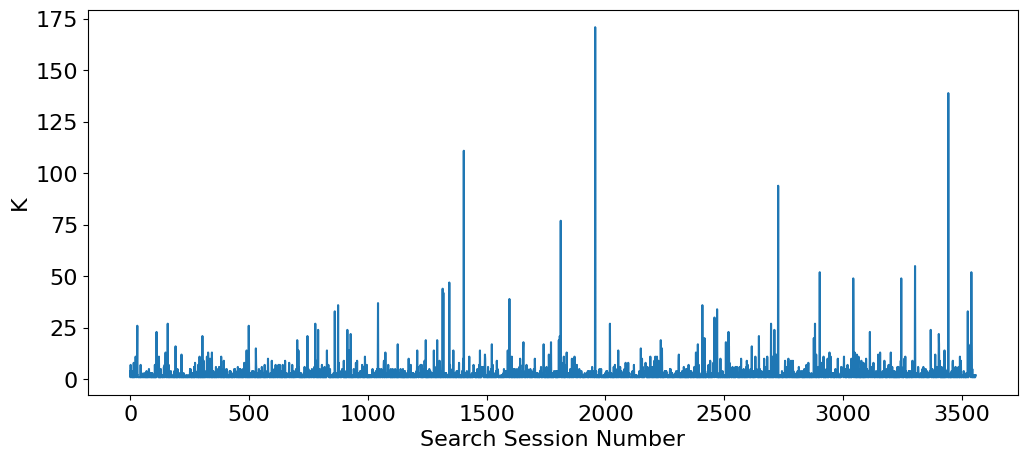

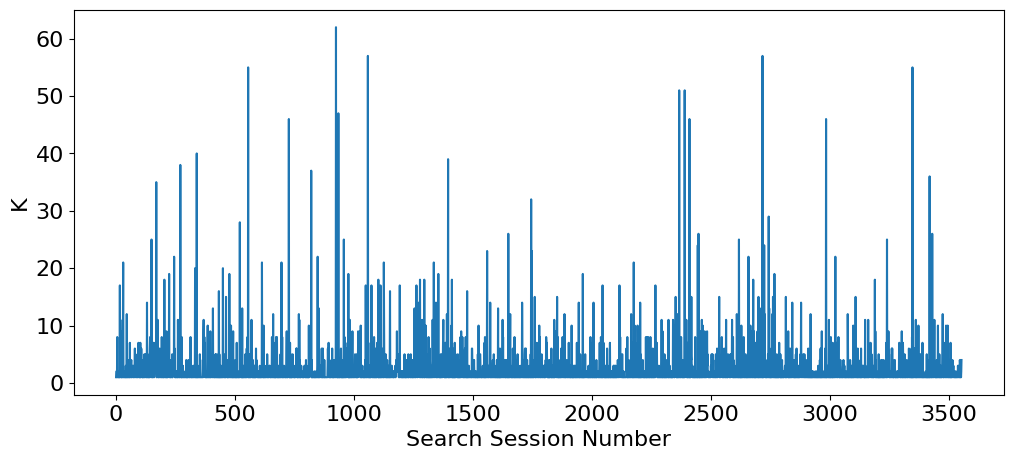

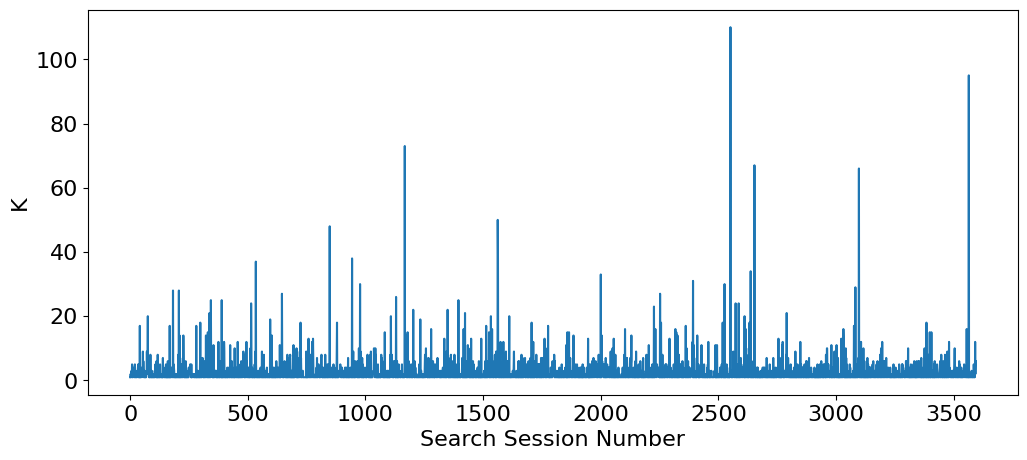

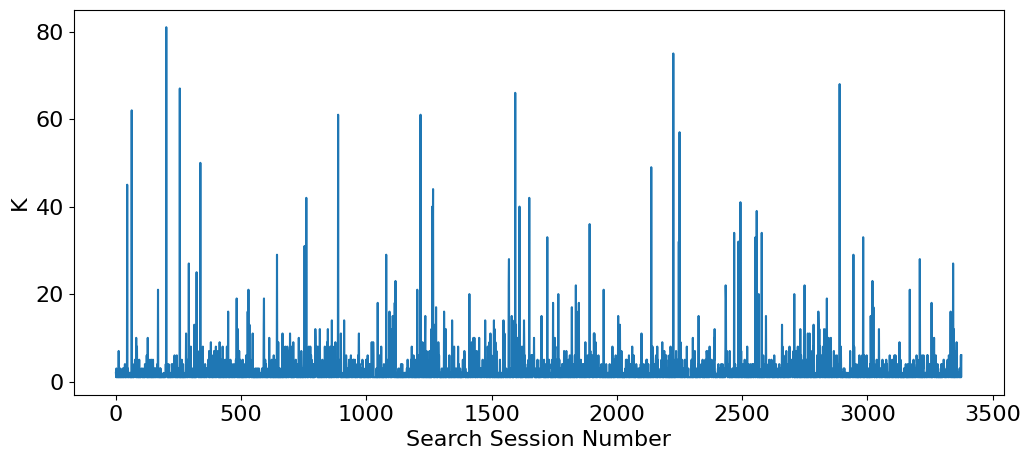

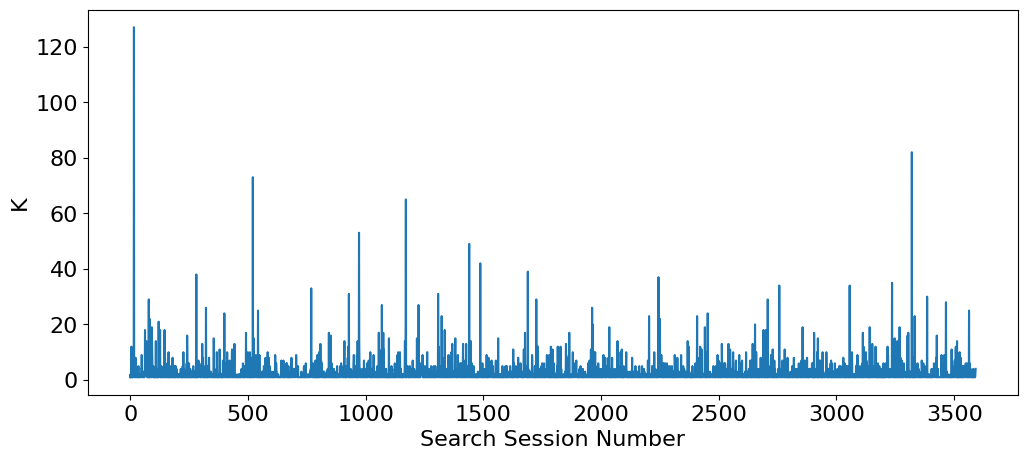

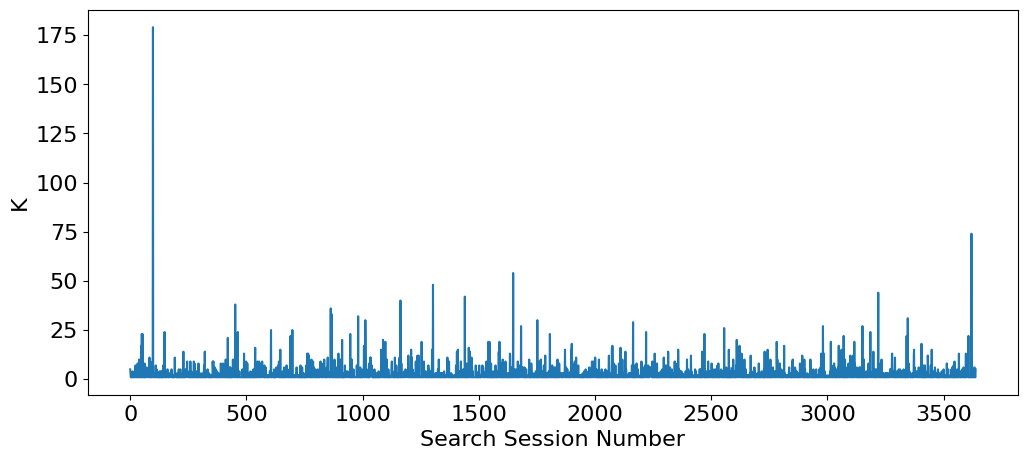

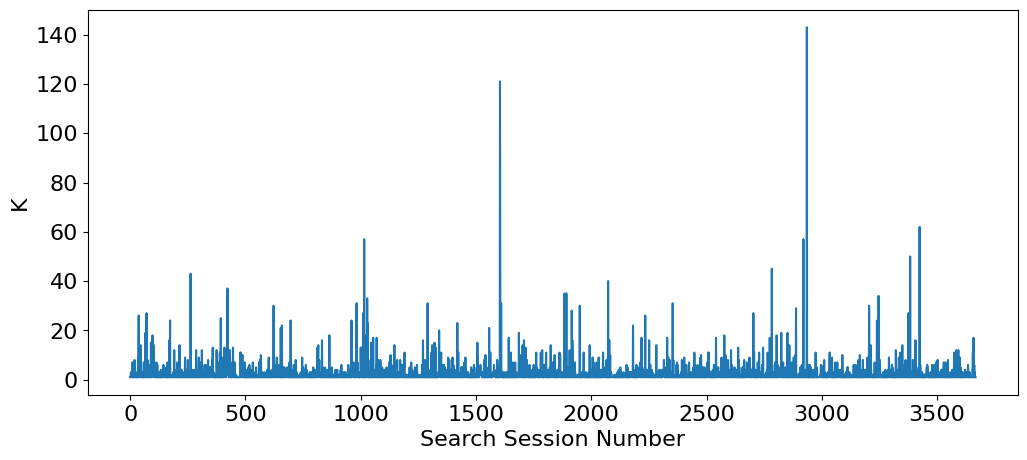

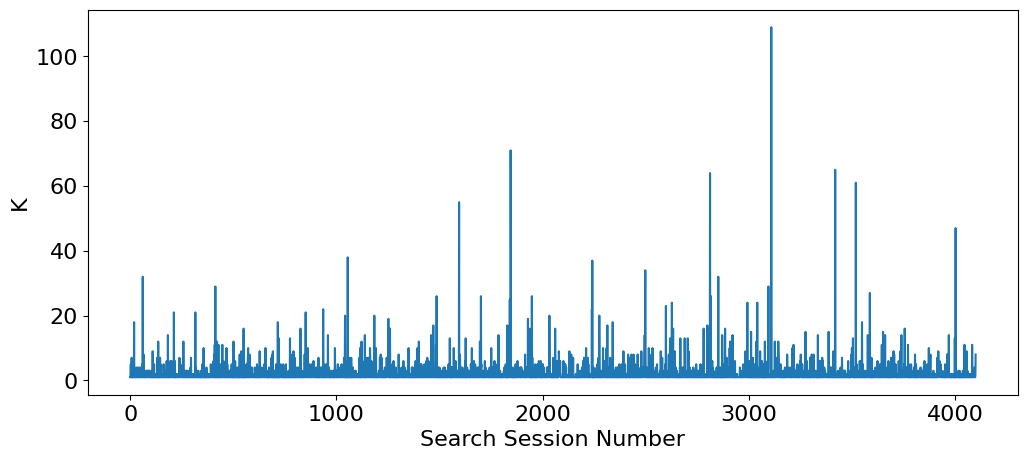

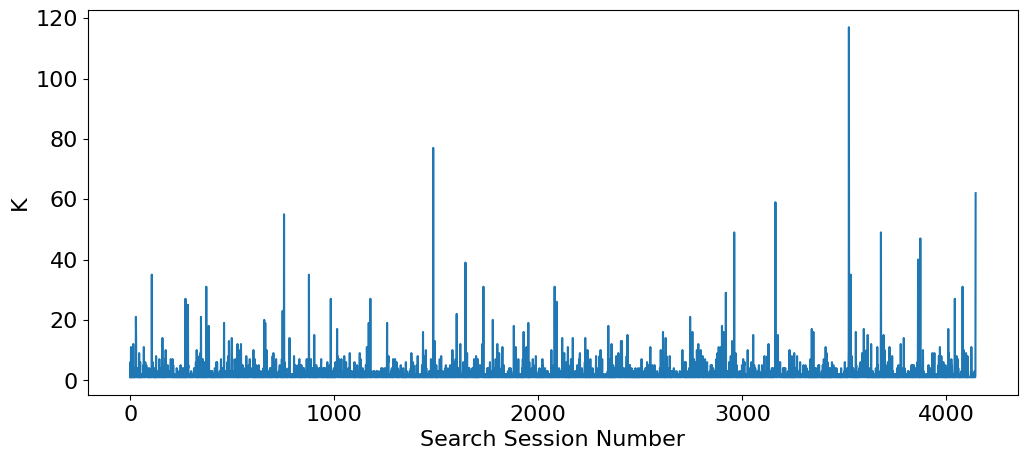

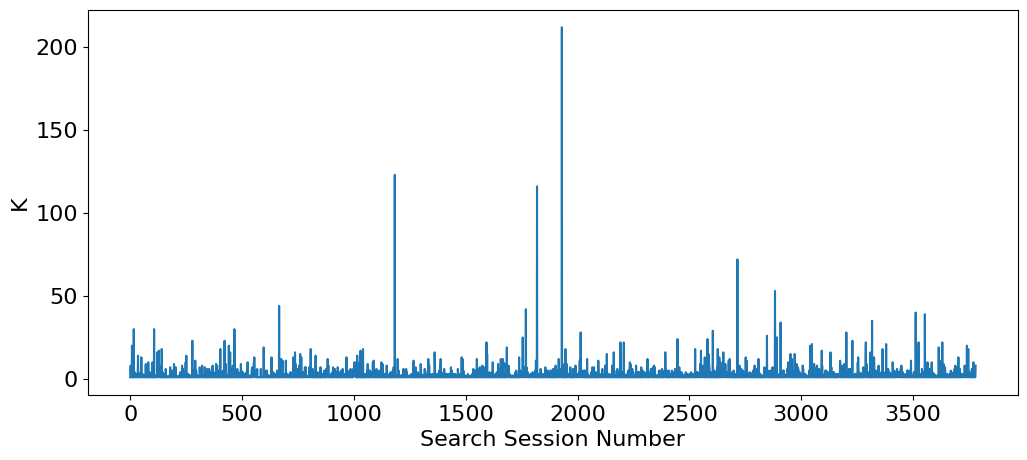

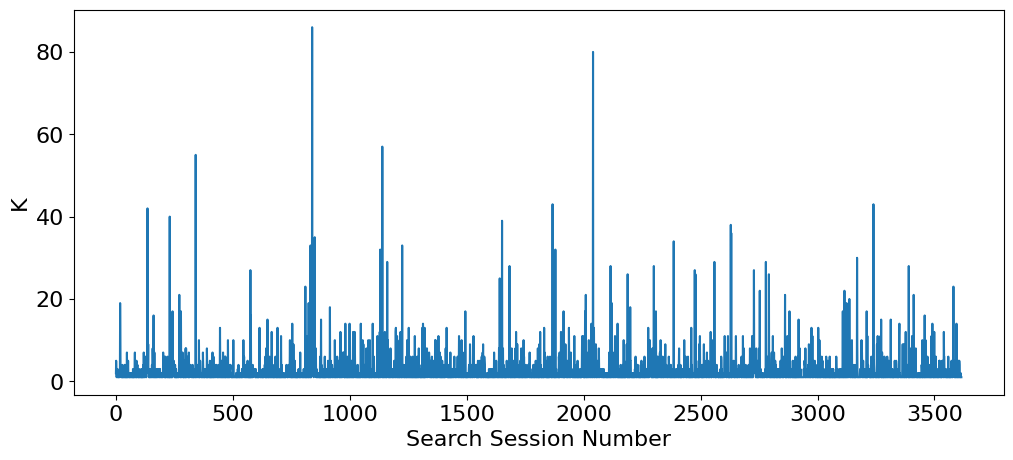

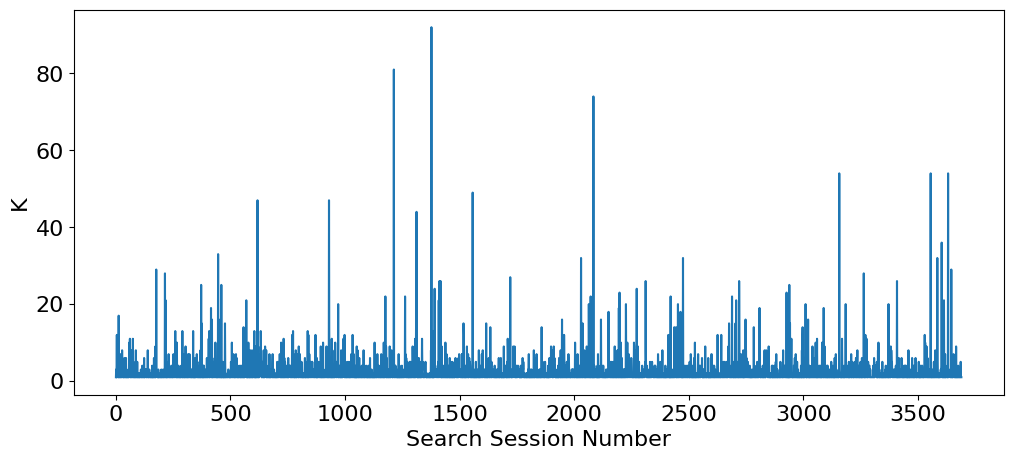

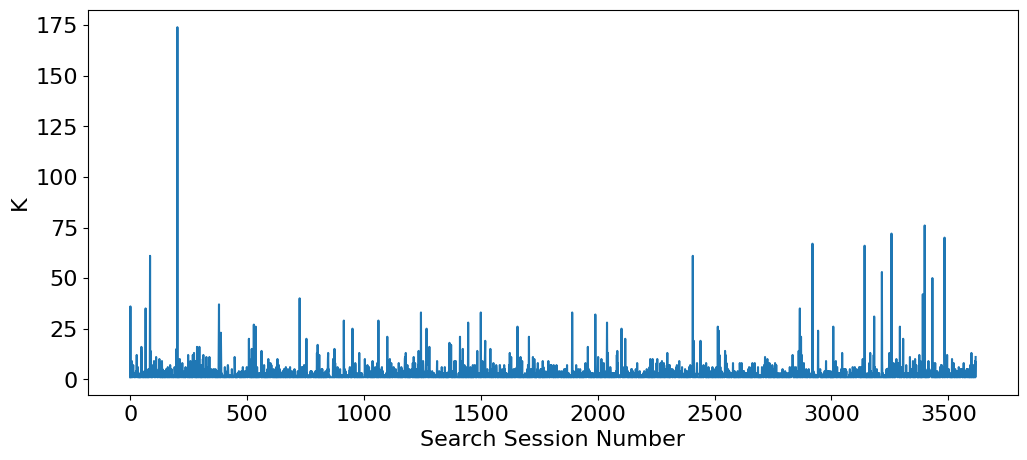

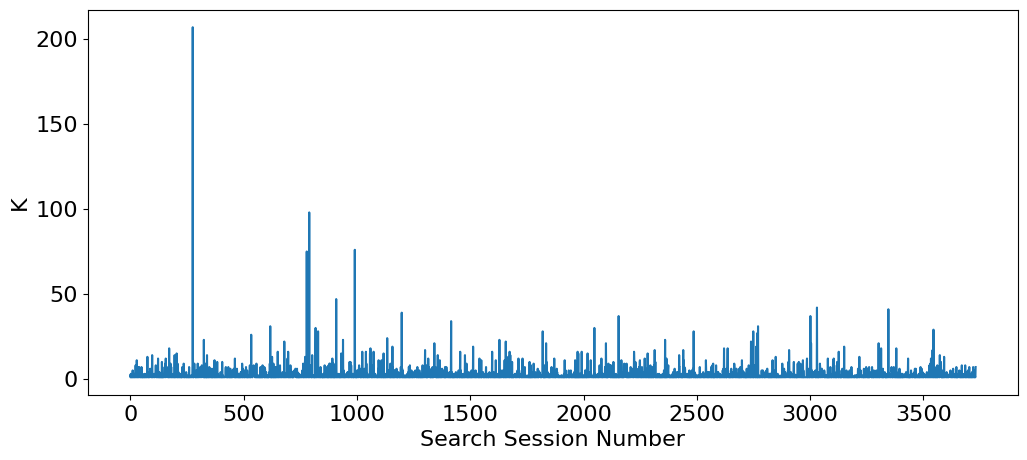

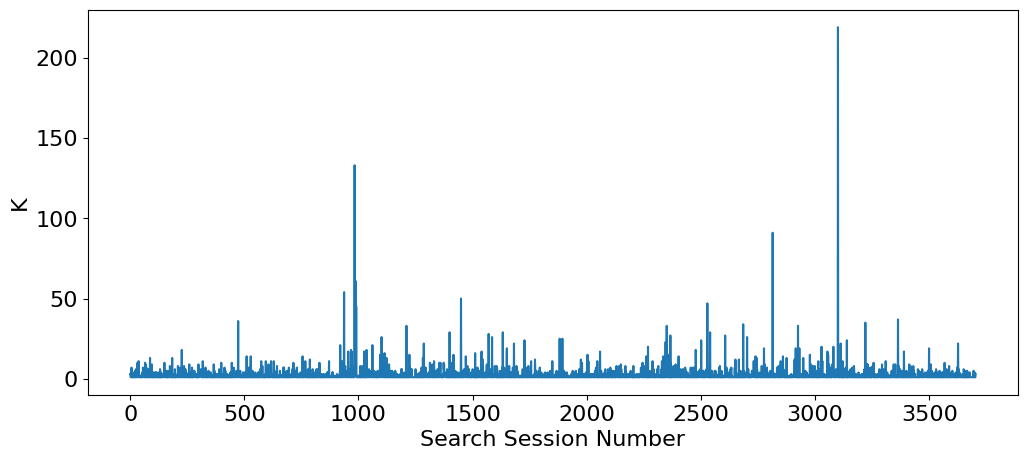

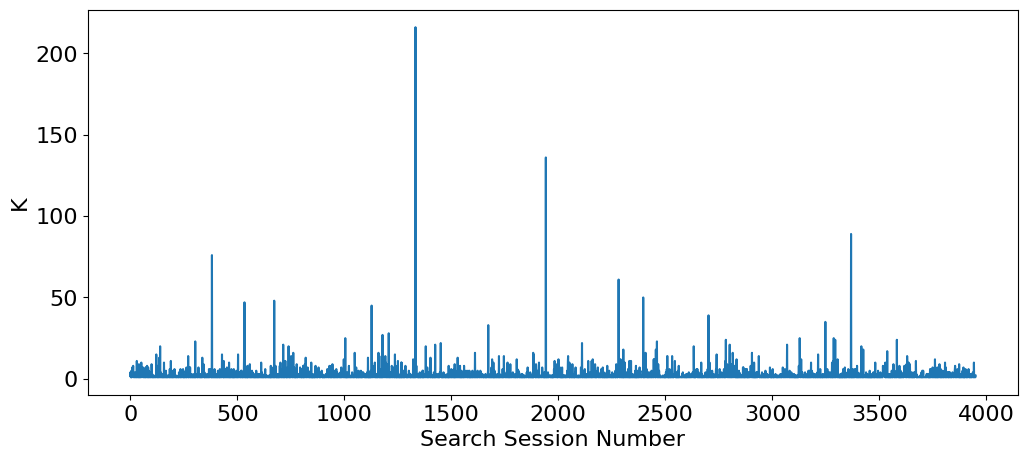

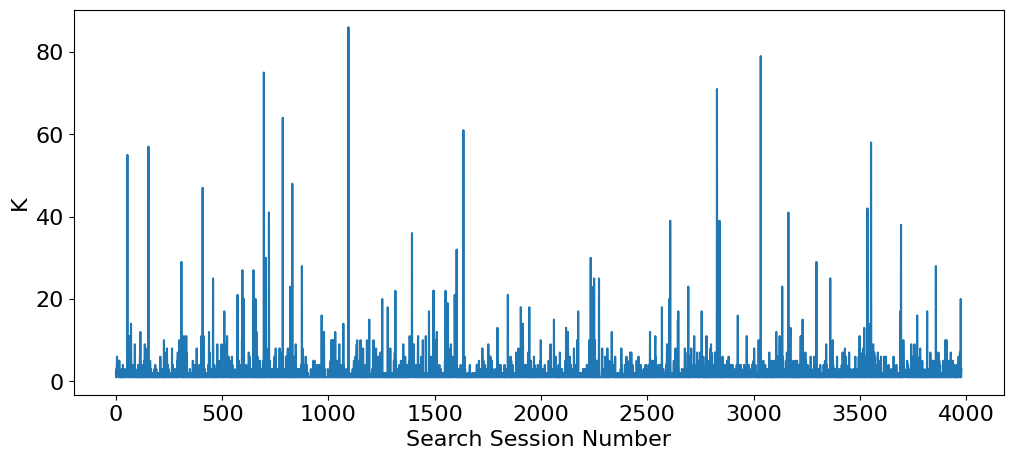

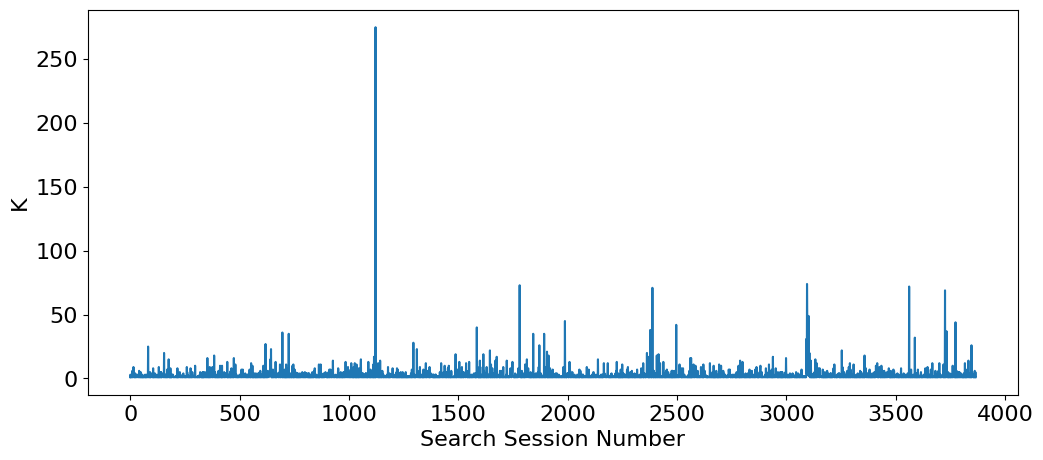

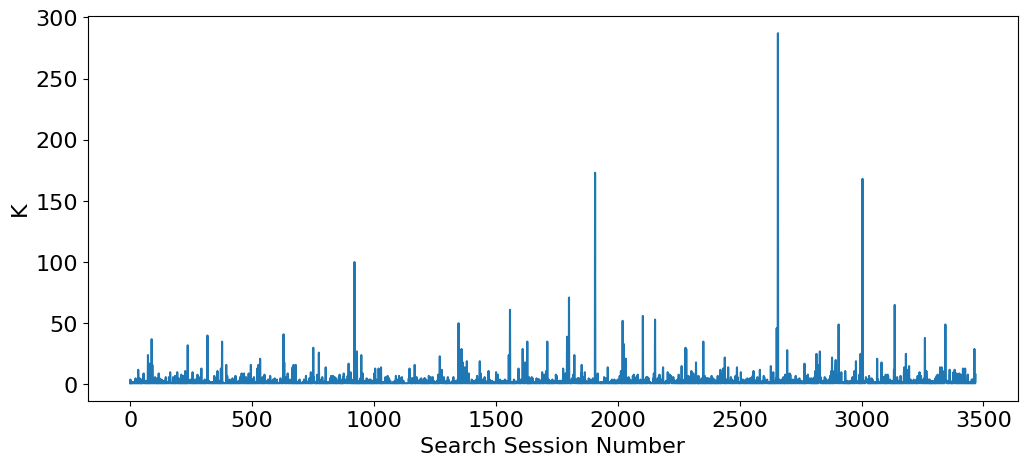

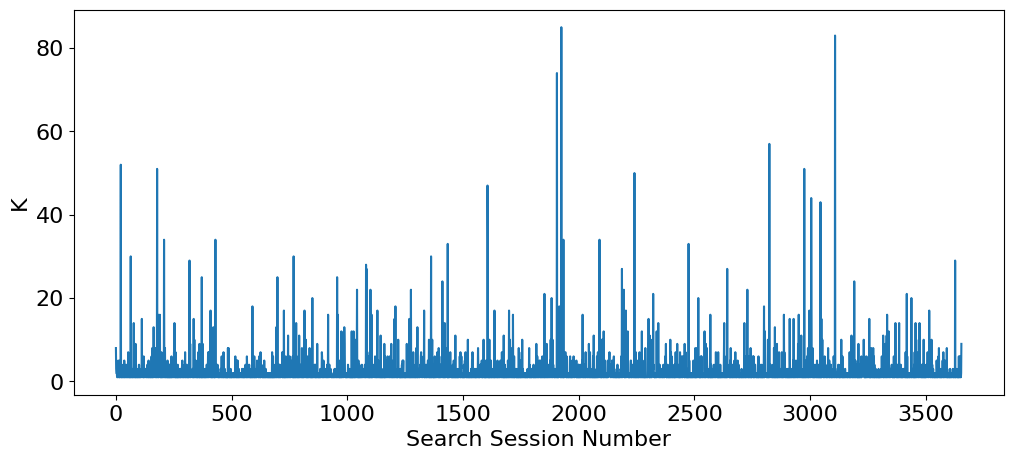

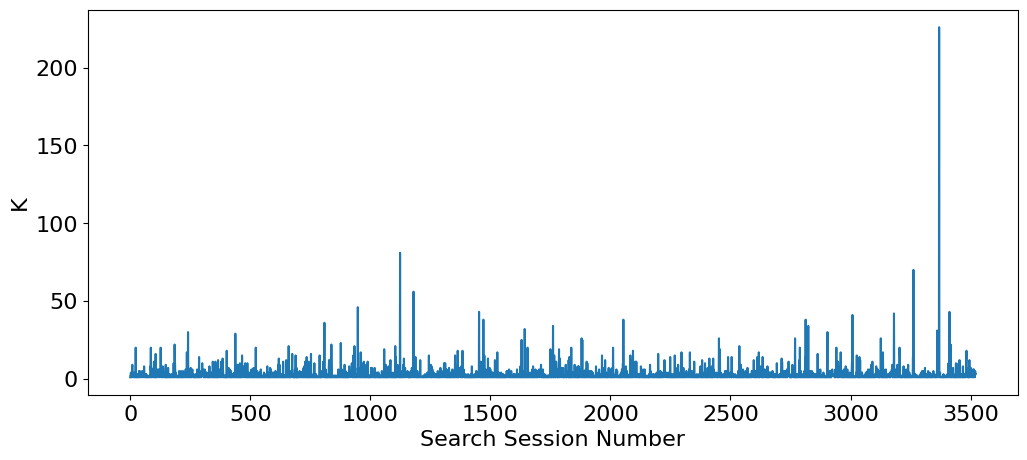

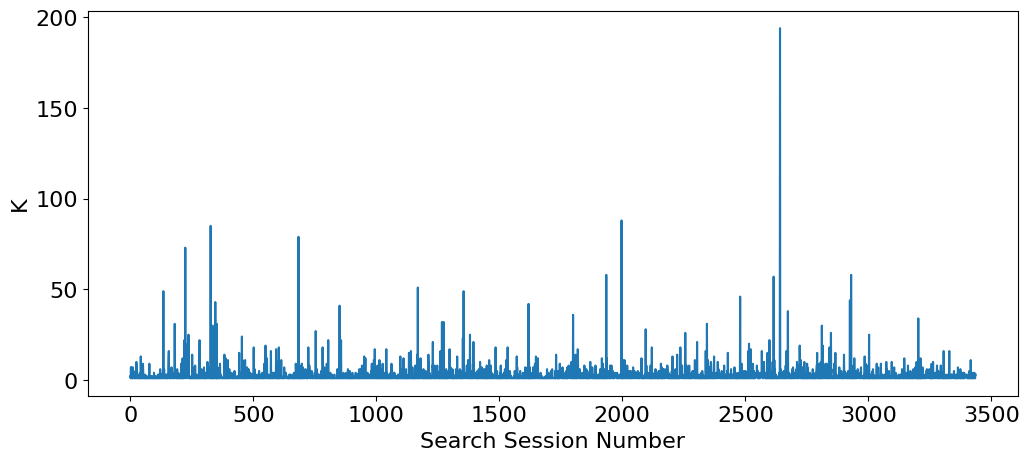

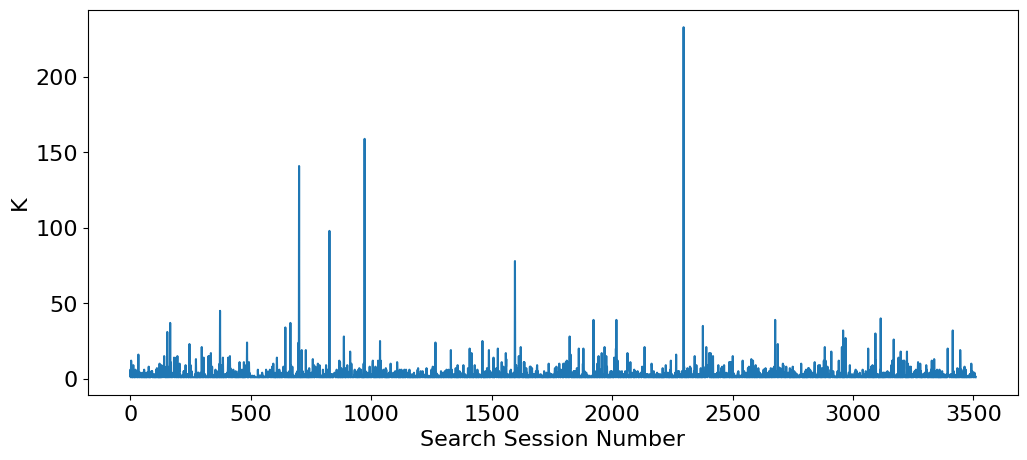

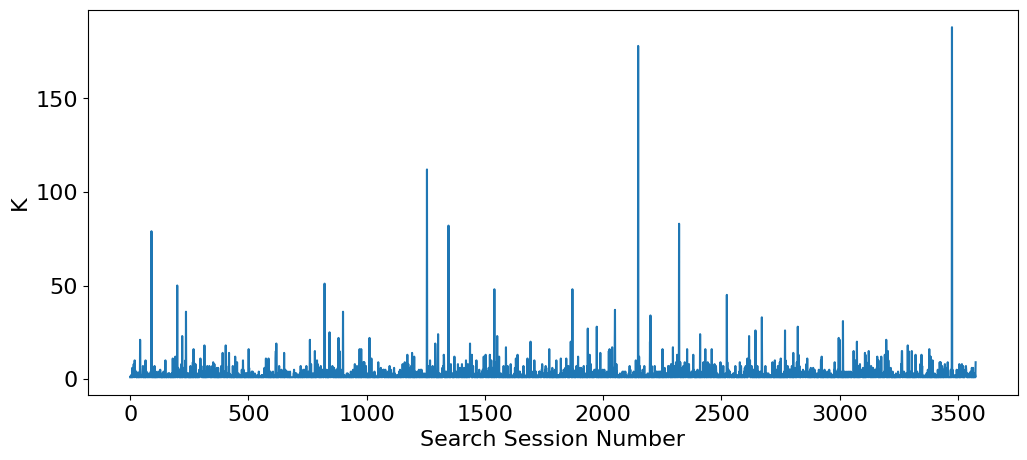

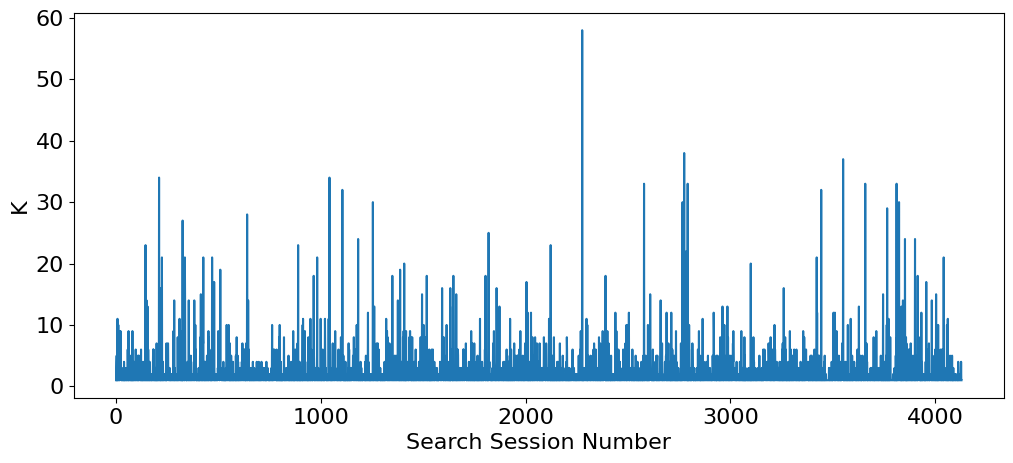

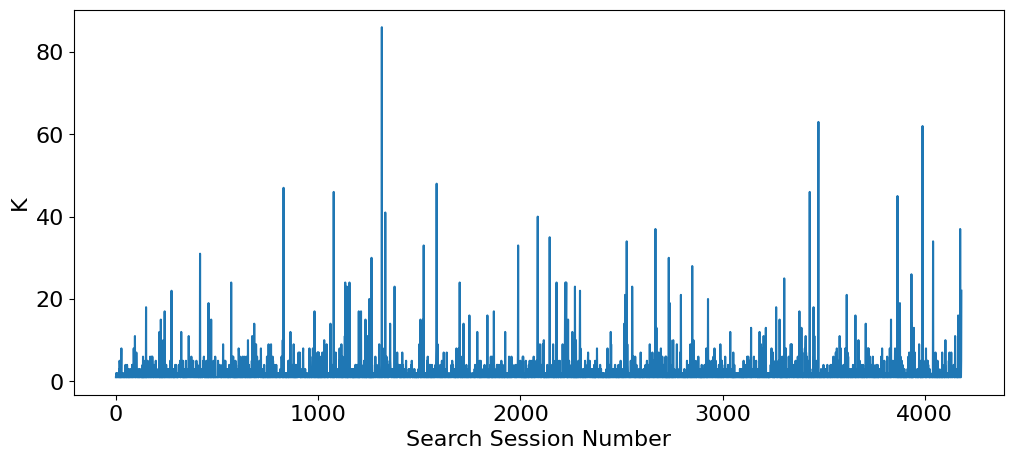

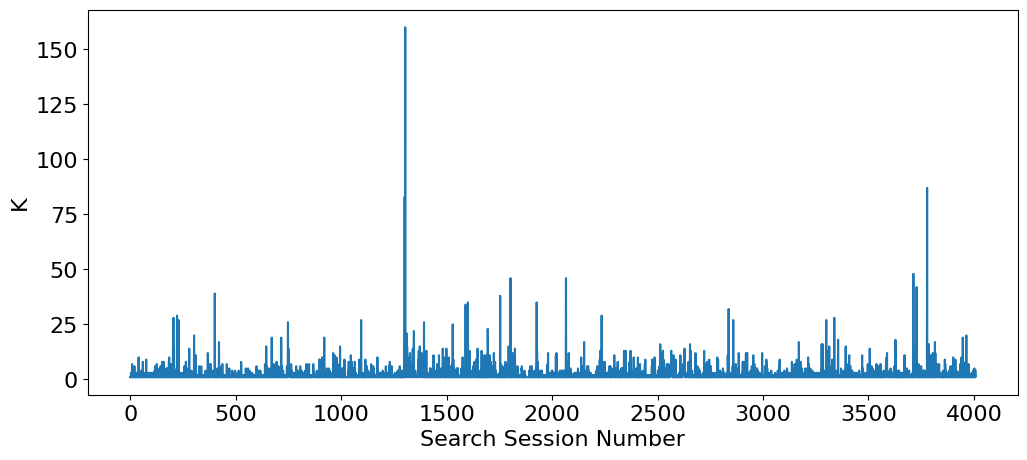

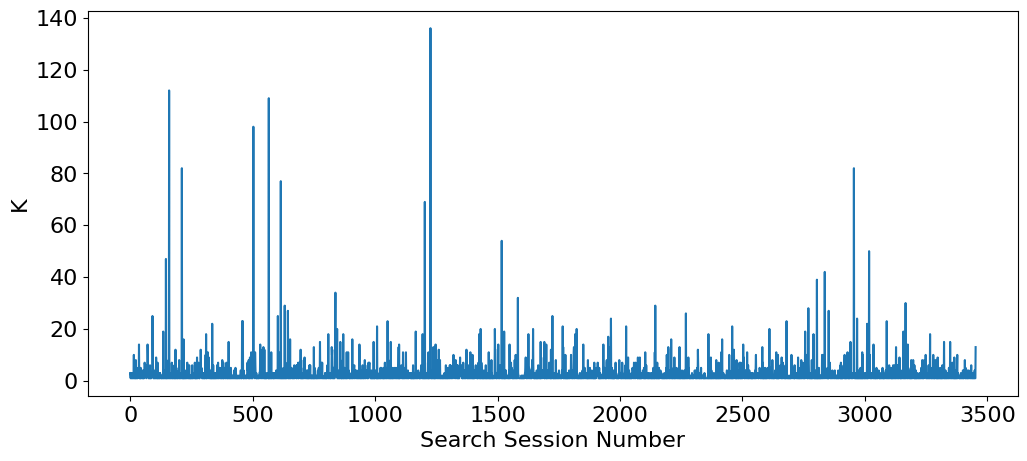

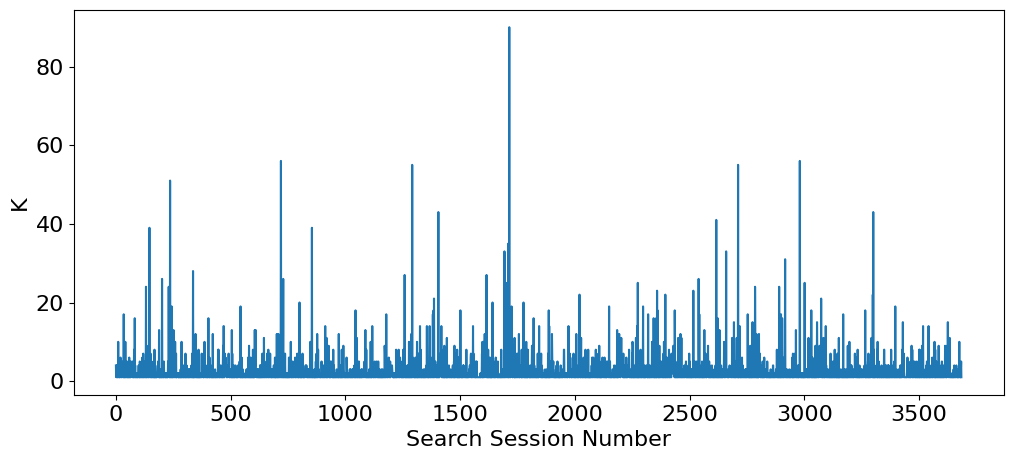

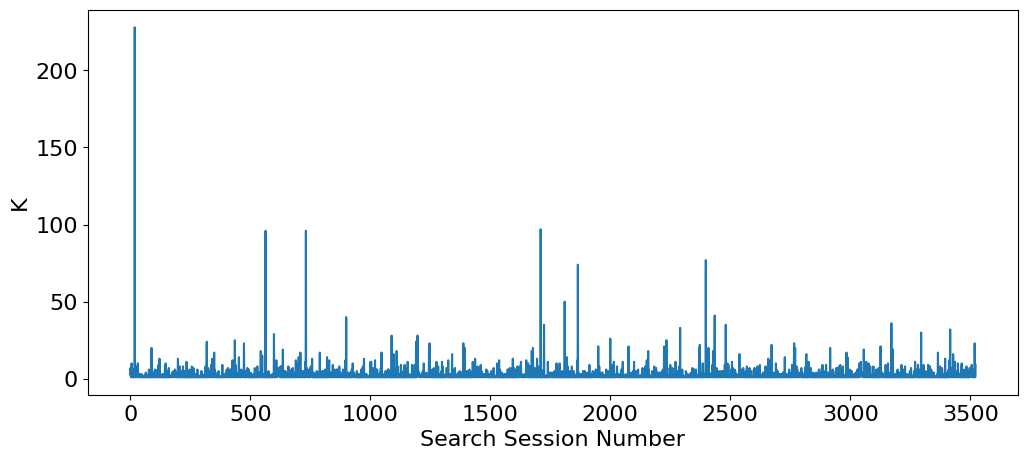

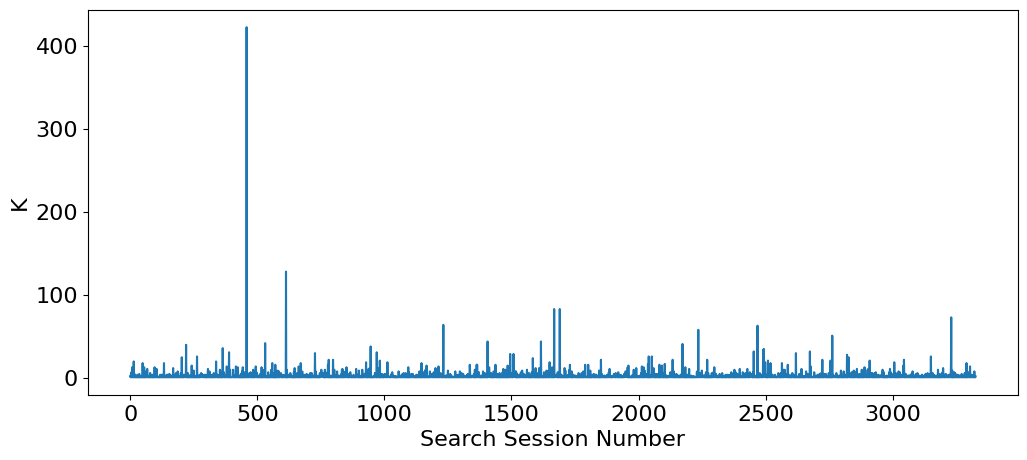

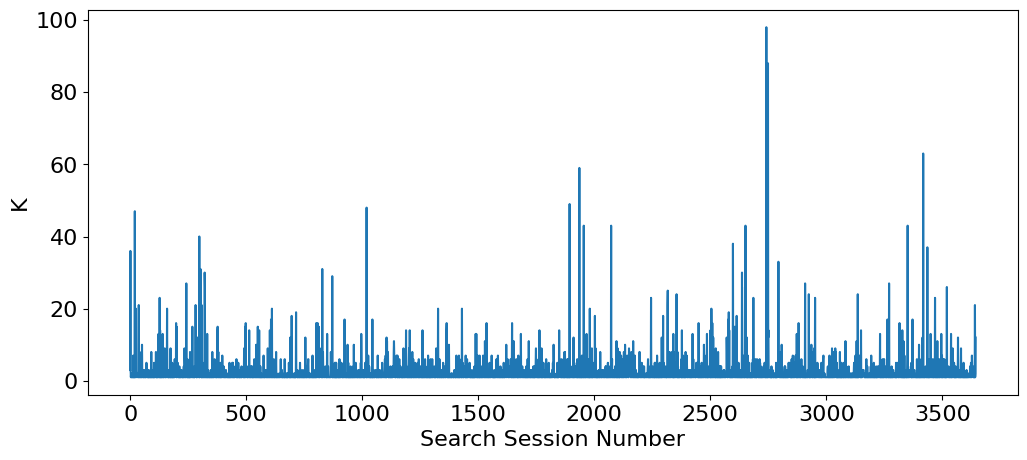

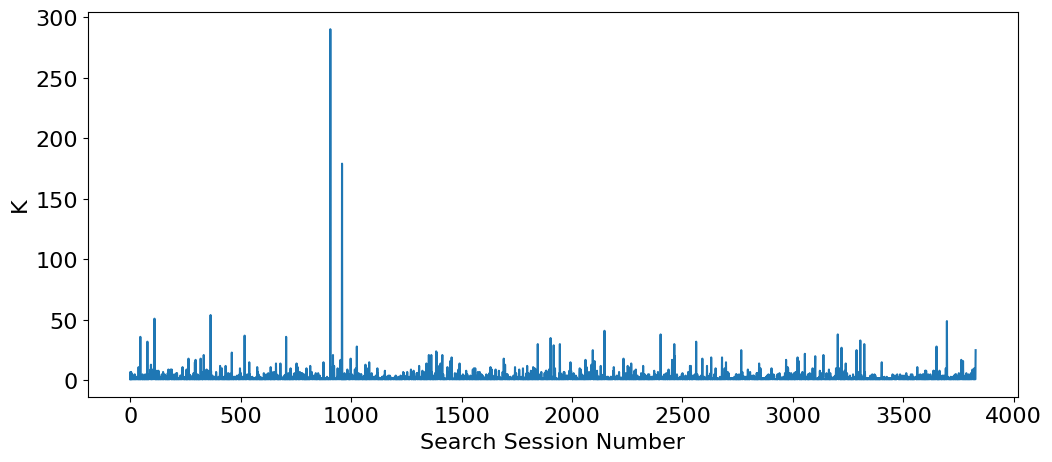

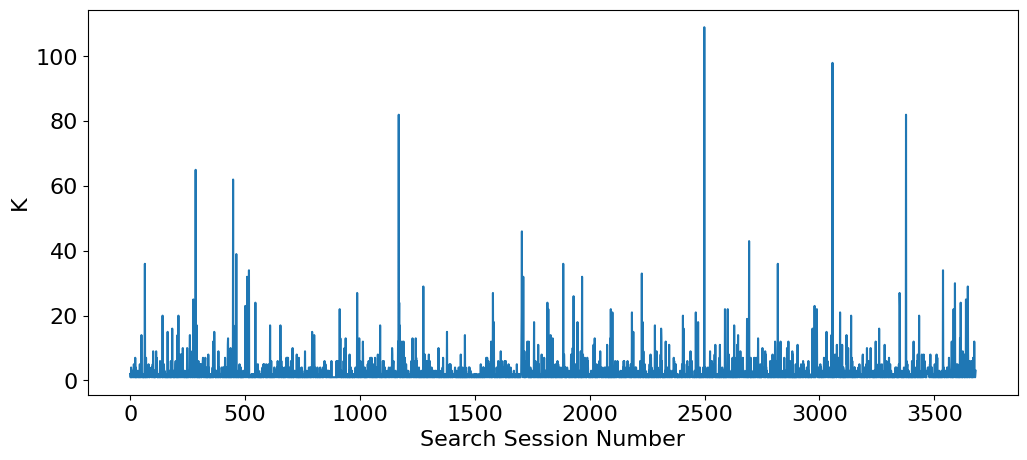

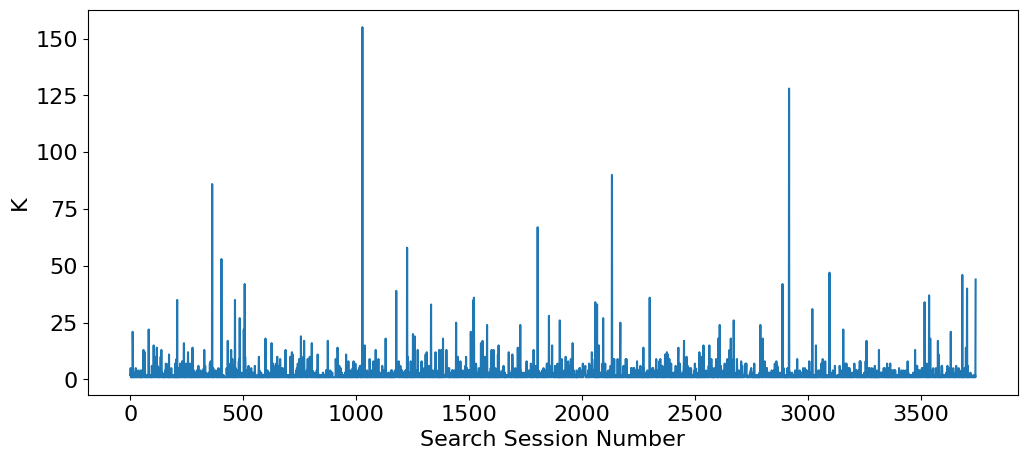

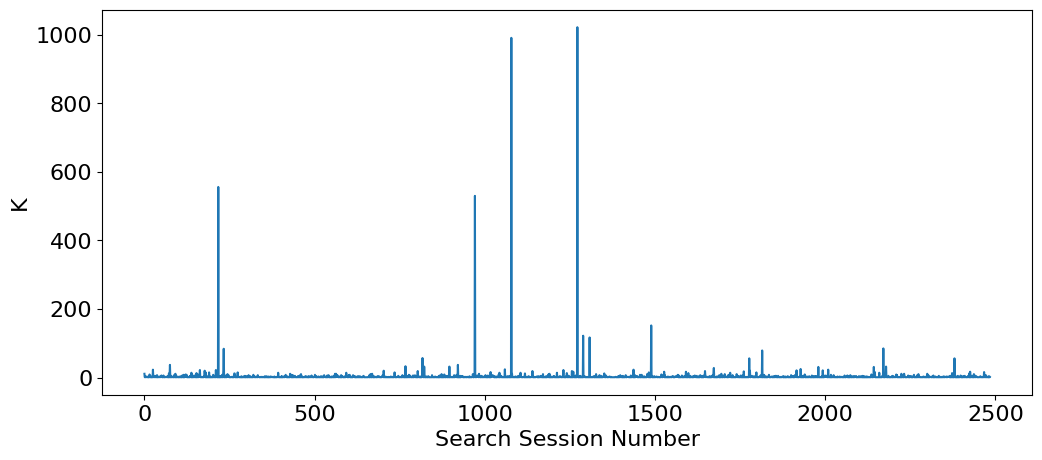

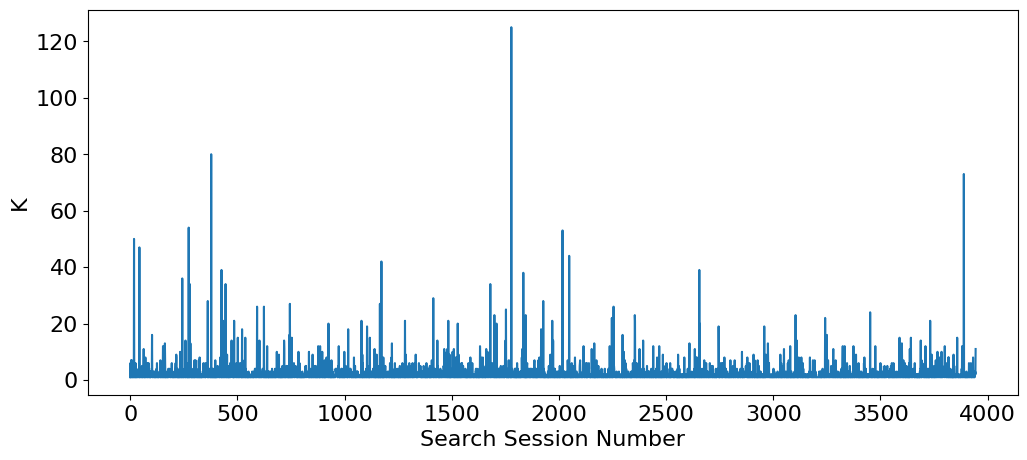

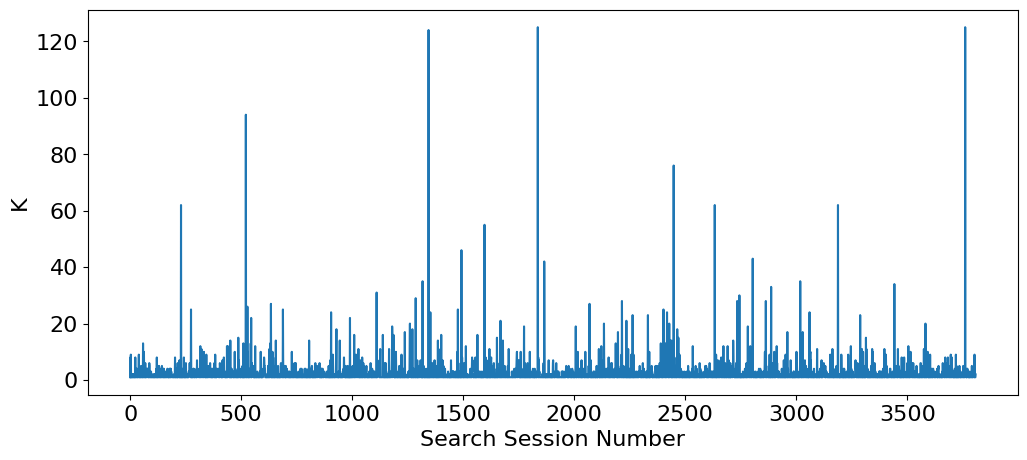

Moyennes de N :  [14.19277108433735, 22.96319018404908, 19.473684210526315, 36.99065420560748, 13.468503937007874, 32.29059829059829, 13.939622641509434, 50.89473684210526, 12.113636363636363, 18.615023474178404, 27.985714285714284, 24.0, 20.691860465116278, 56.3968253968254, 32.37837837837838, 41.170731707317074, 28.0625, 20.216666666666665, 25.47222222222222, 37.28181818181818, 35.11864406779661, 17.751173708920188, 41.5632183908046, 39.68817204301075, 20.674285714285713, 17.9375, 16.836363636363636, 18.207373271889402, 45.735632183908045, 14.01086956521739, 12.04513888888889, 42.5, 15.515418502202643, 17.625641025641027, 15.0, 18.92063492063492, 69.98305084745763, 48.06896551724138, 24.900621118012424, 25.204379562043794, 40.494505494505496, 15.384279475982533, 7.865248226950355, 36.81818181818182, 13.154639175257731, 33.46363636363636, 24.0, 2.429130009775171, 31.30952380952381, 30.23015873015873, 36.18867924528302, 18.75, 49.59036144578313, 24.6875, 17.847926267281107, 29.05633802

In [14]:
#Calcul de l'ensemble des N et K pour les différents blocs de session et affichage des valeurs de K par session number pour chaque bloc de sessions
K = [[] for i in range(len(blocs))]
N = [[] for i in range(len(blocs))]
NMean = [0 for i in range(len(blocs))]
KMean = [0 for i in range(len(blocs))]
indiceBloc=0
for numBloc in blocs:
    sessions = creeTableauSessions(numBloc)
    estimationNK(sessions, indiceBloc)
    indiceBloc +=1

print("Moyennes de N : ", NMean)
print("Moyennes de K : ", KMean)

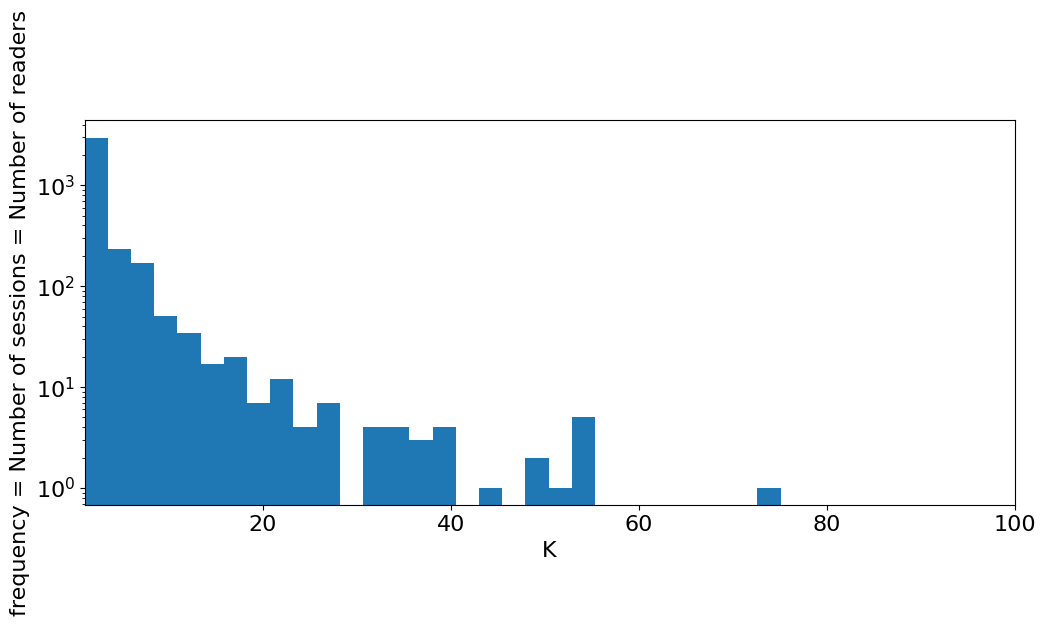

K max =  248


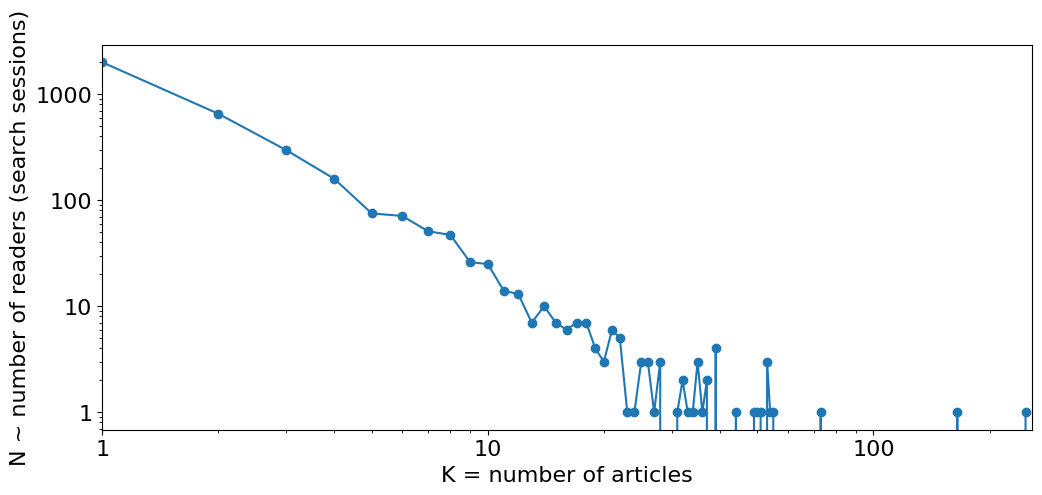

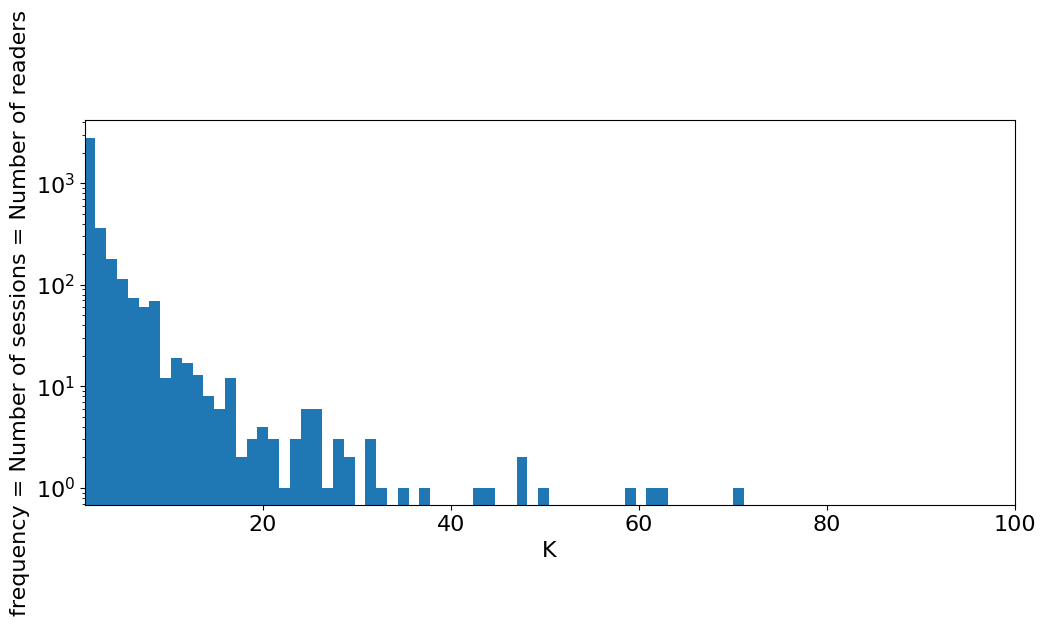

K max =  116


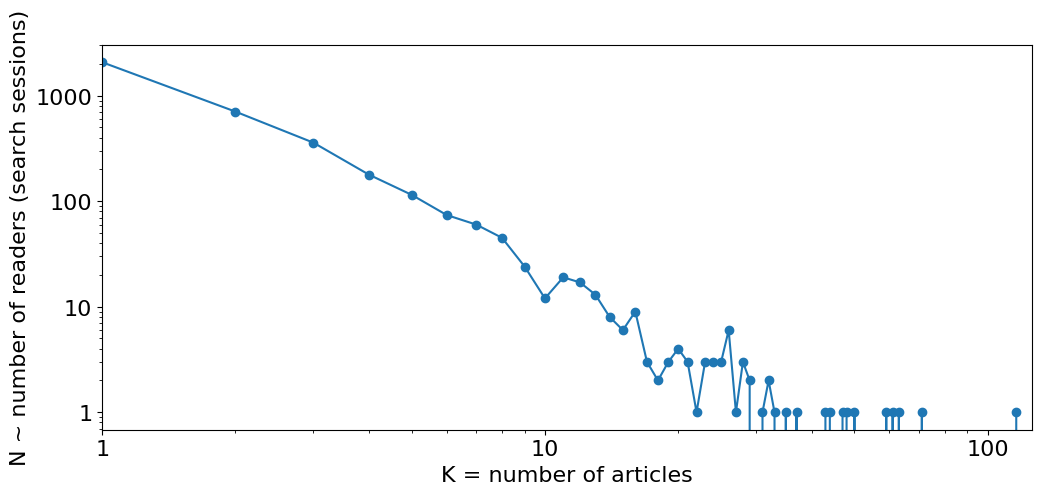

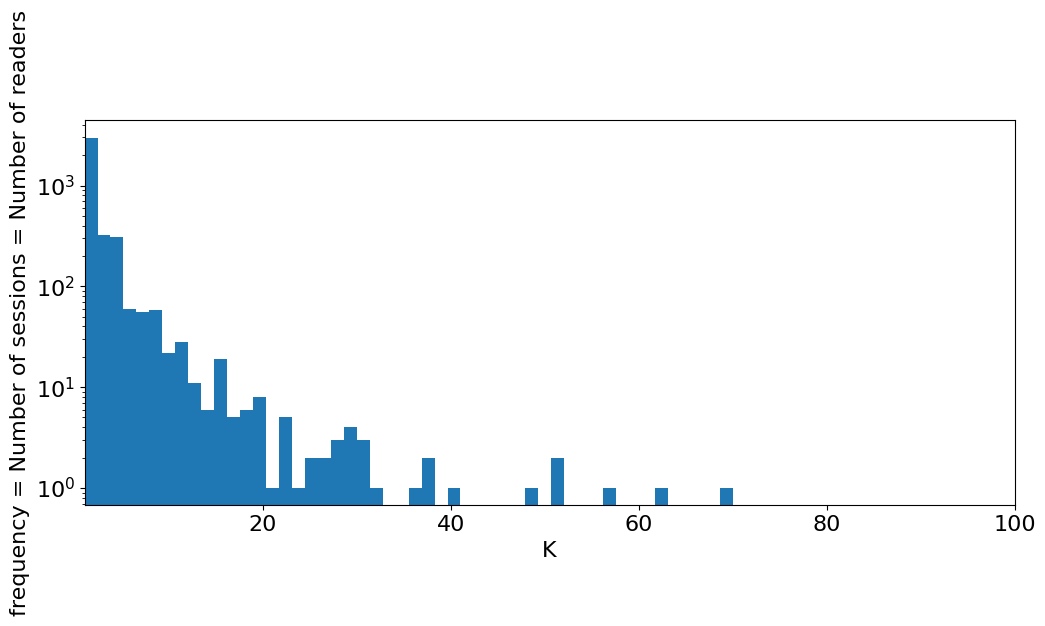

K max =  139


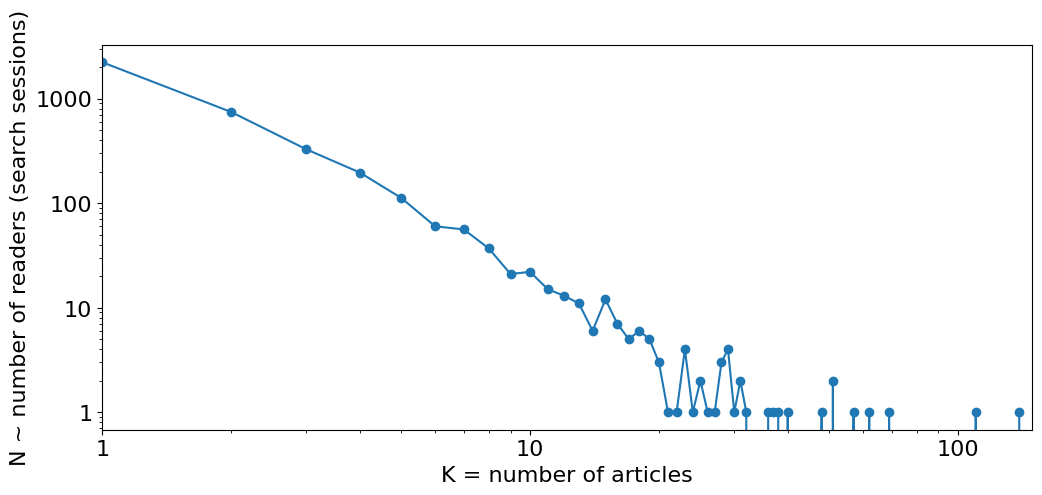

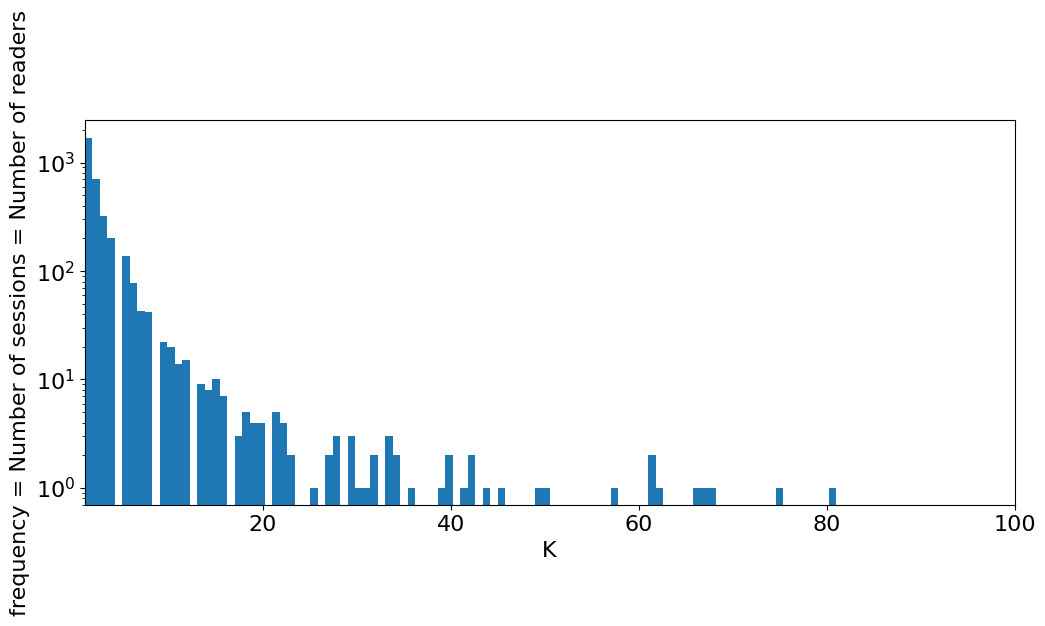

K max =  81


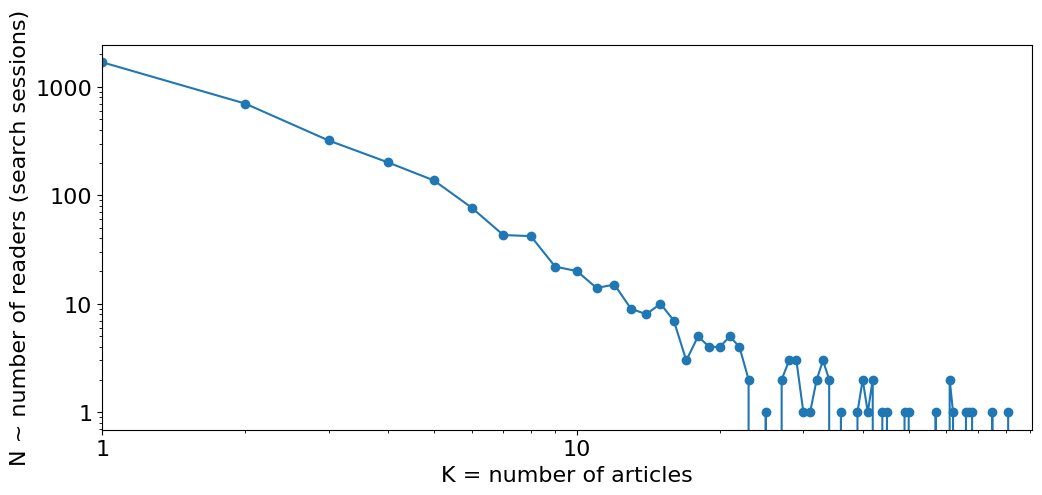

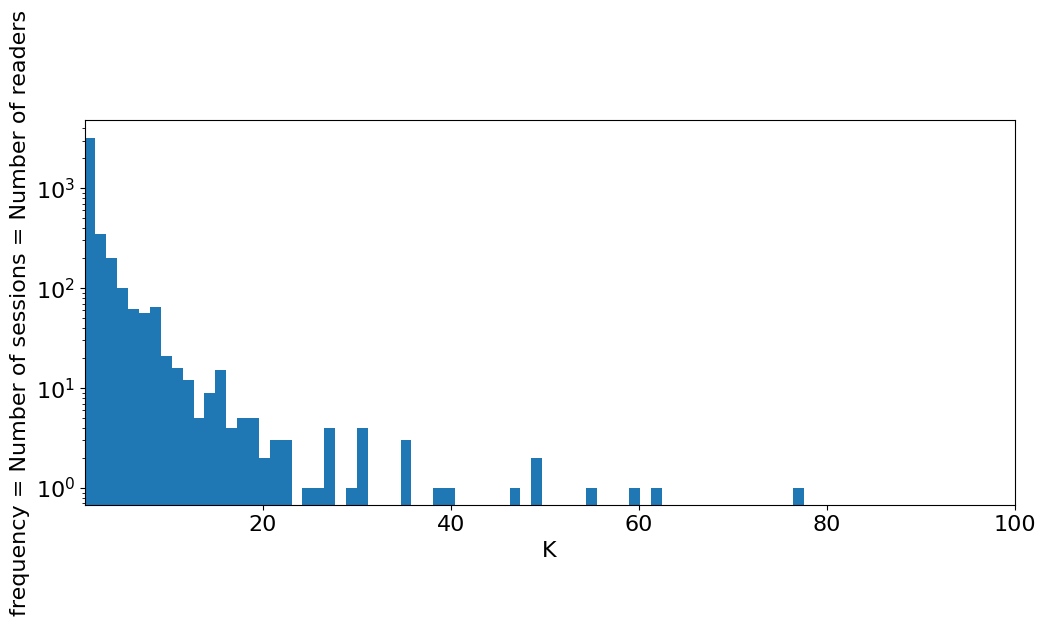

K max =  117


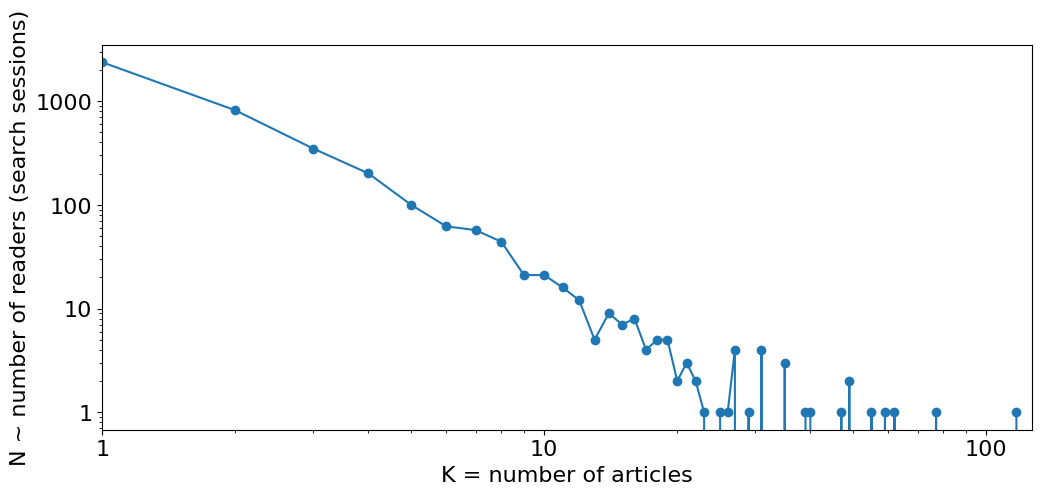

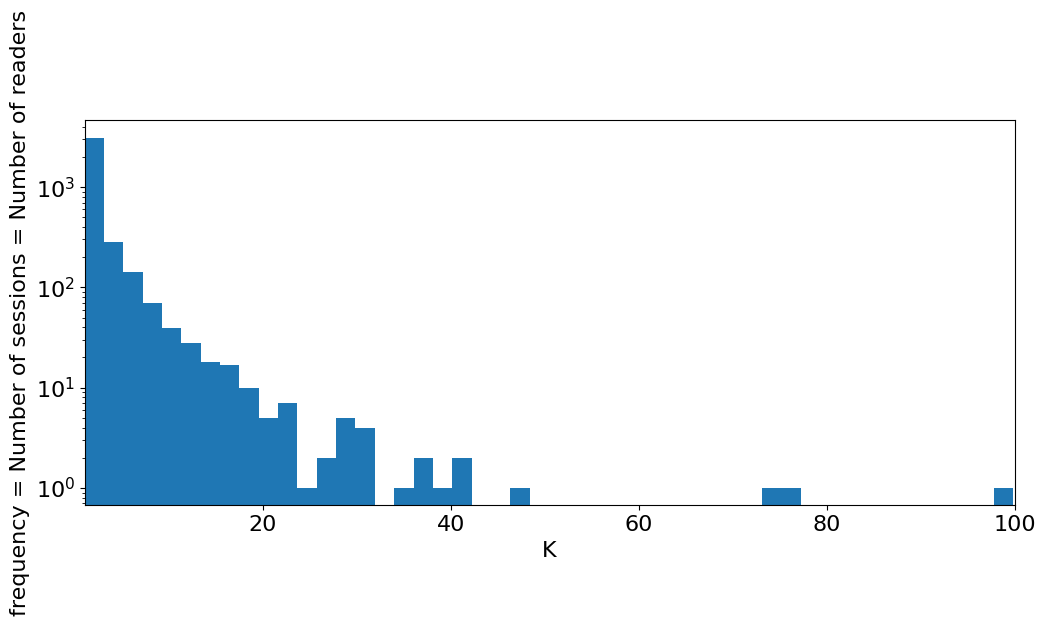

K max =  207


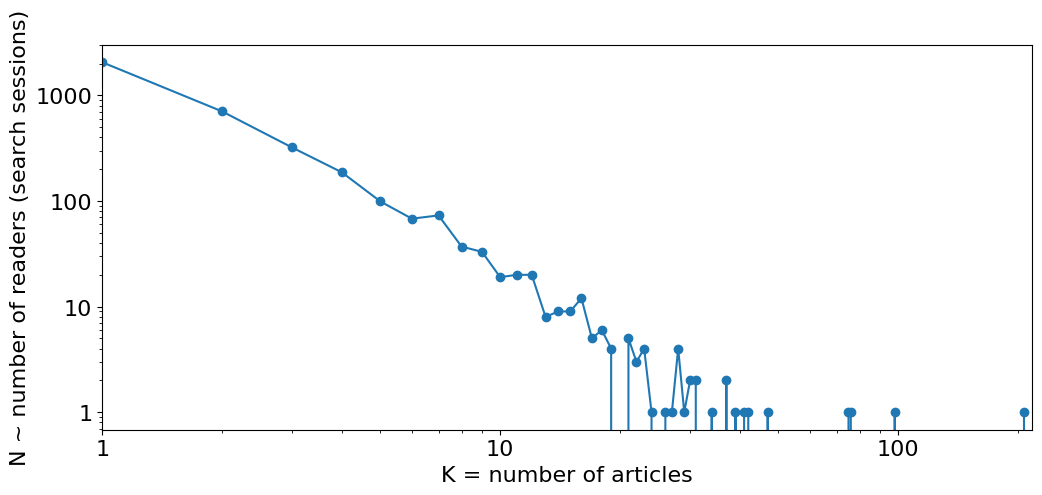

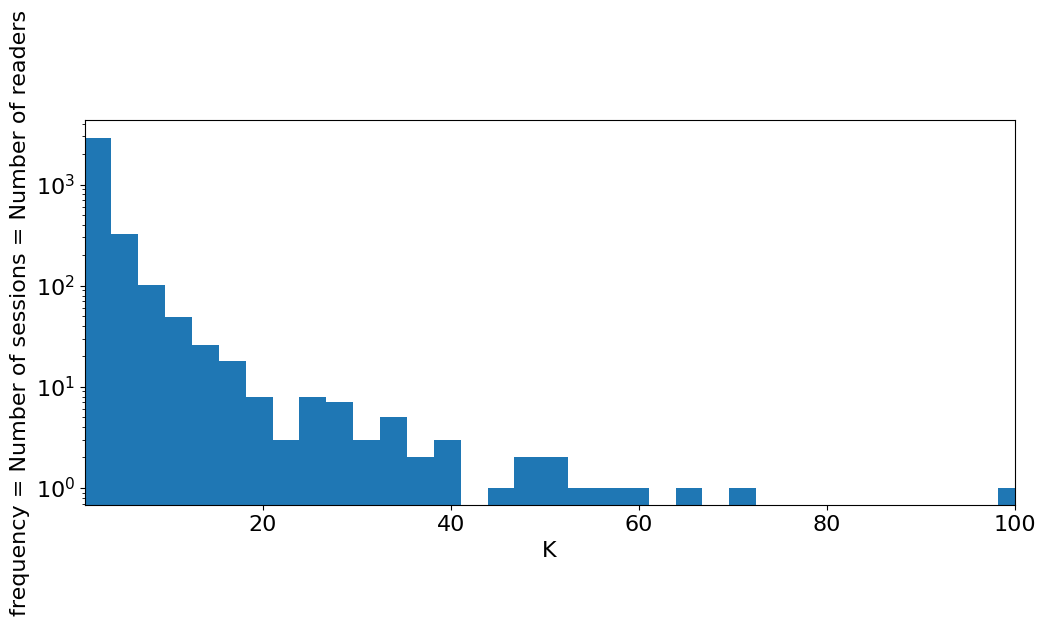

K max =  287


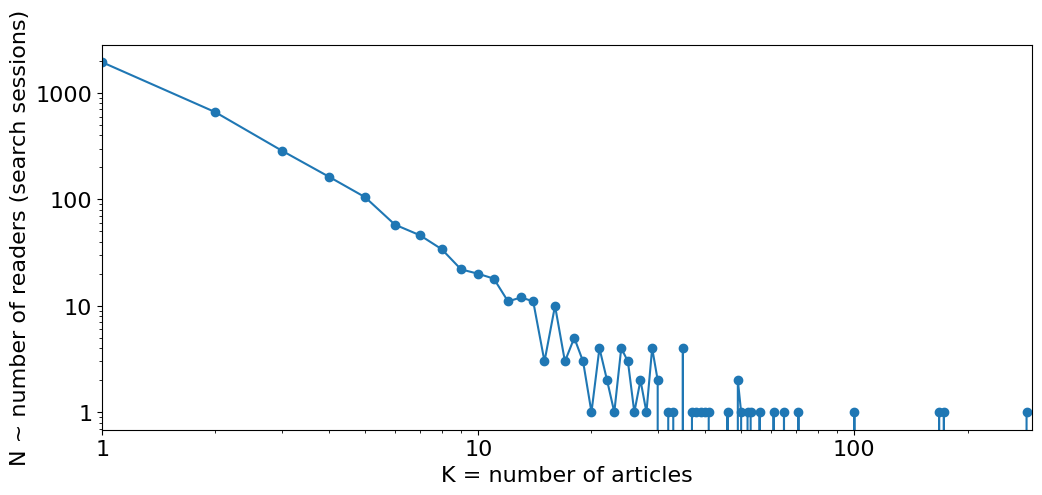

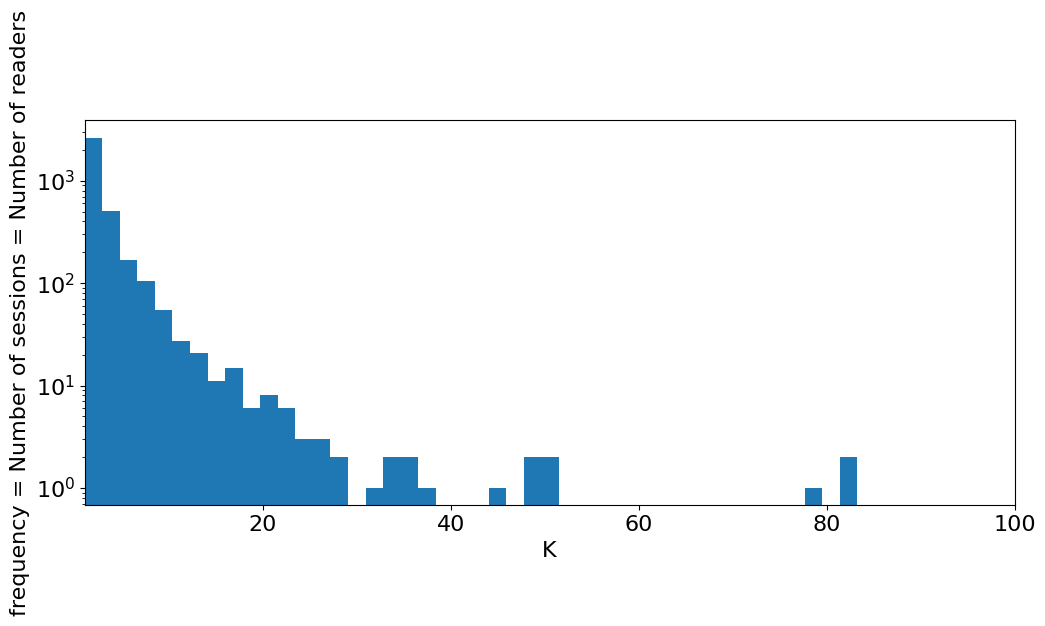

K max =  188


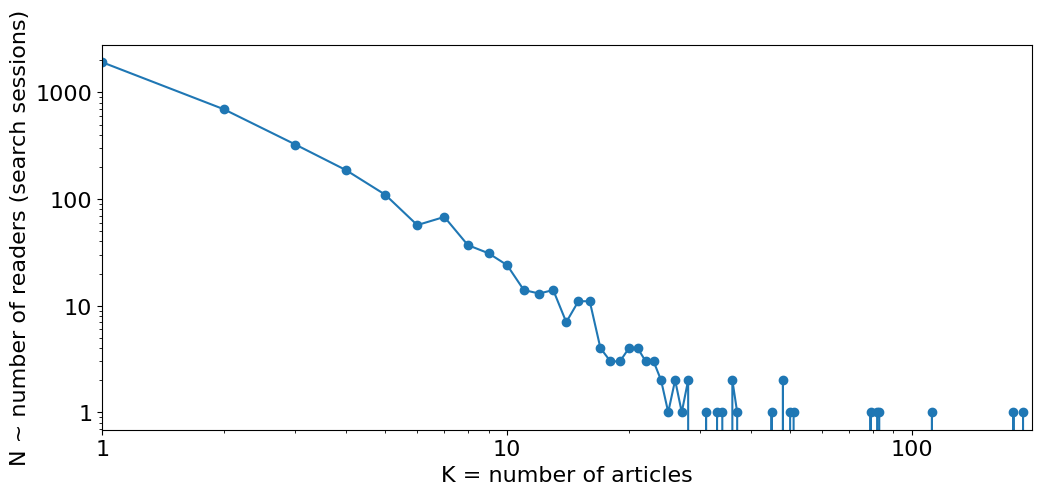

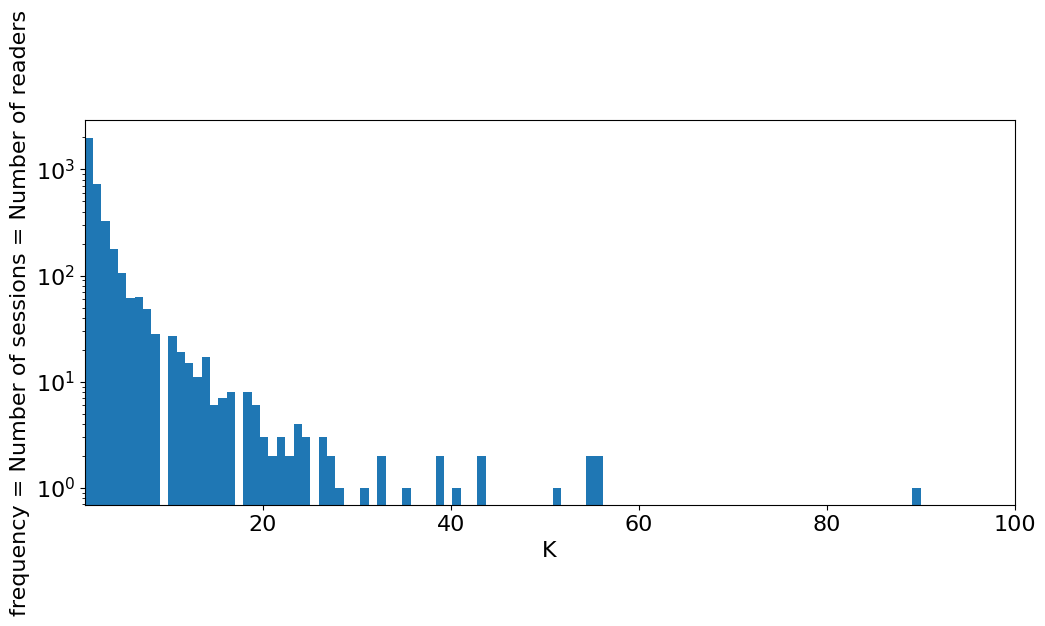

K max =  90


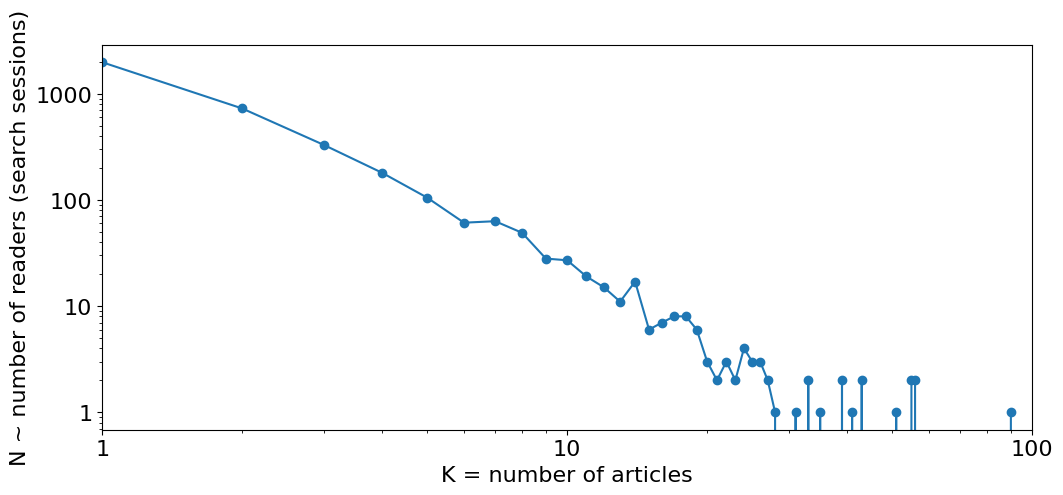

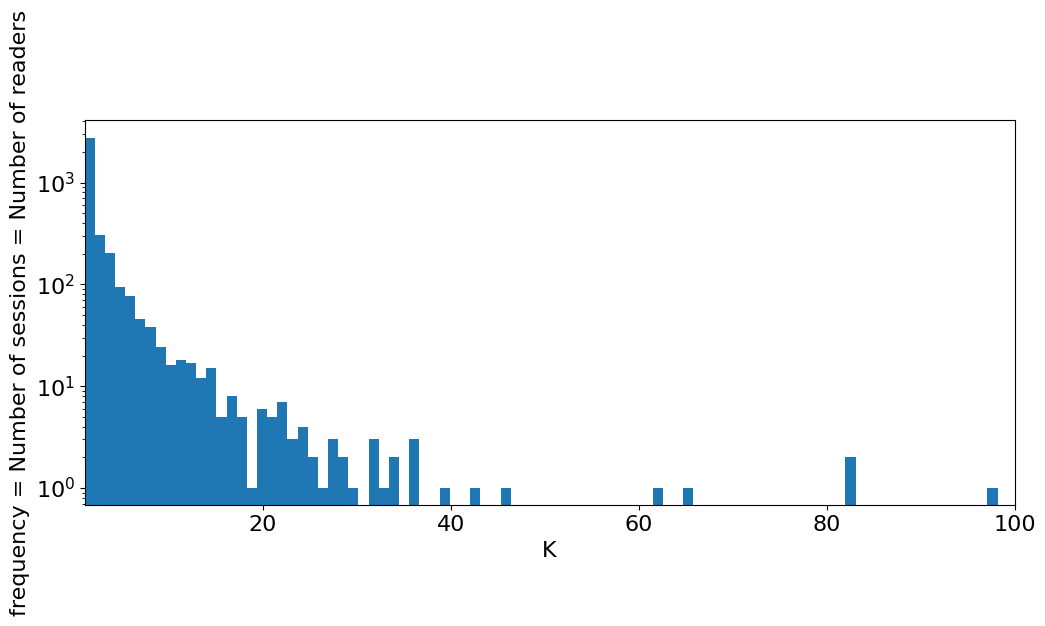

K max =  109


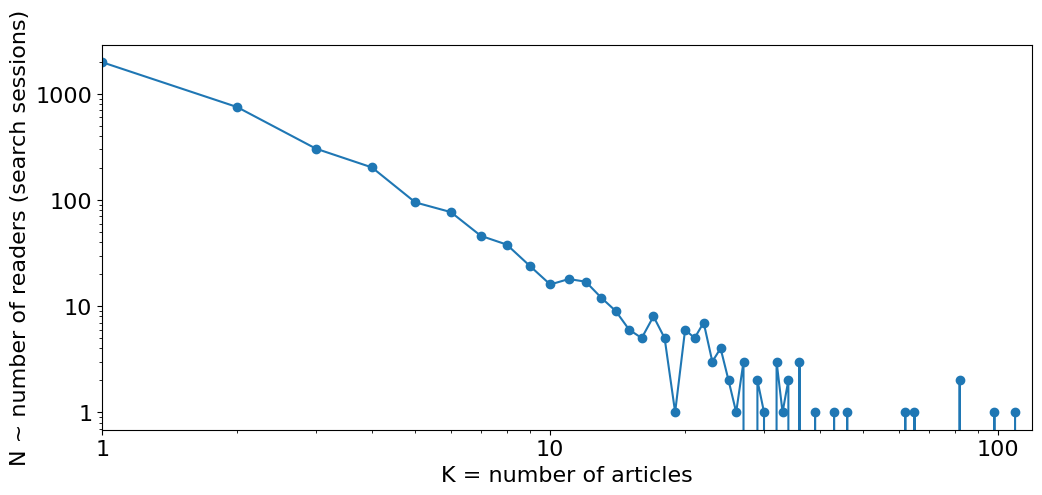

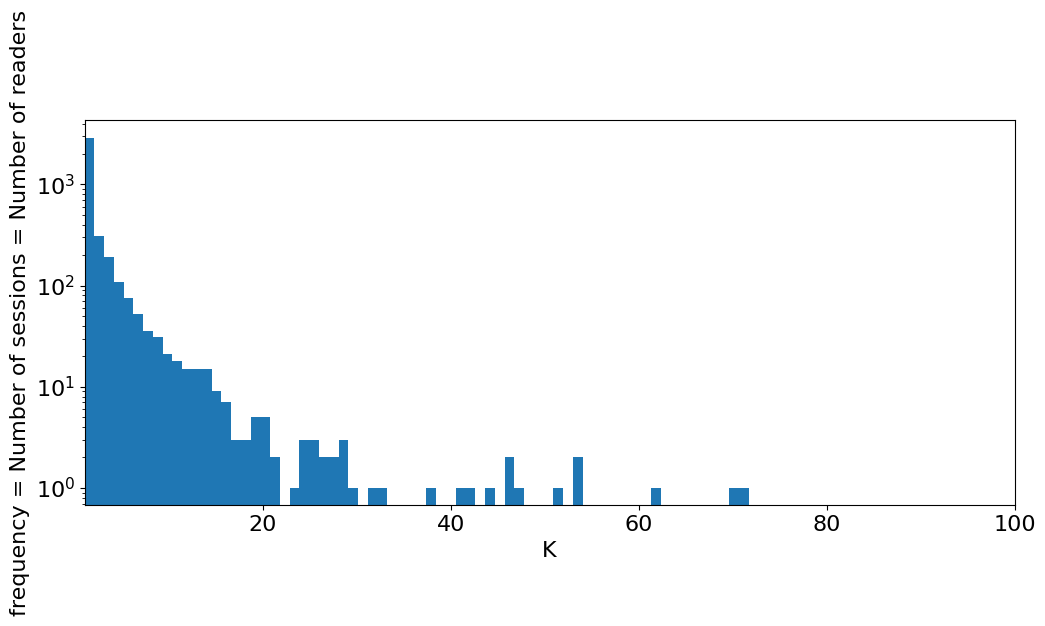

K max =  105


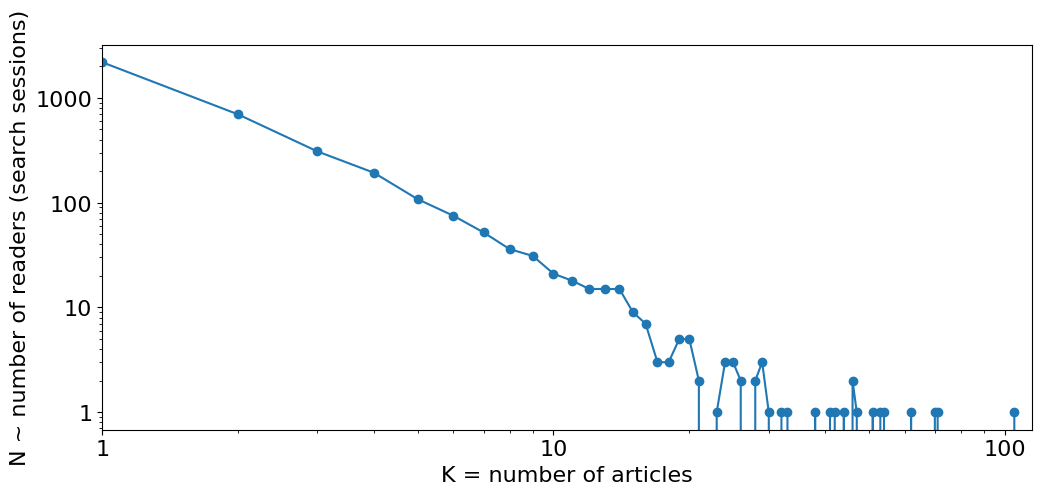

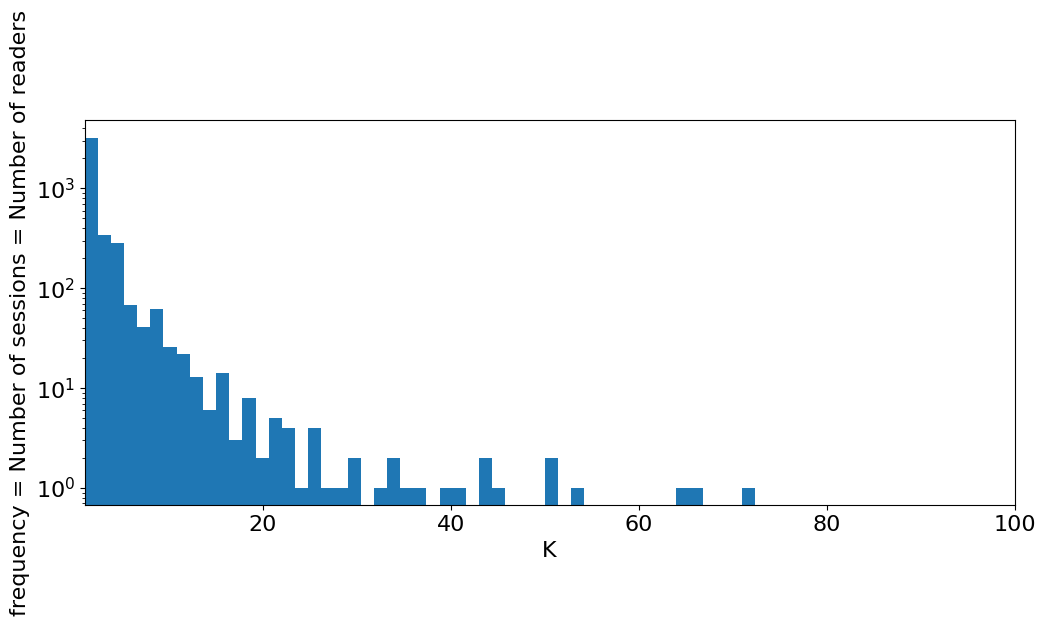

K max =  141


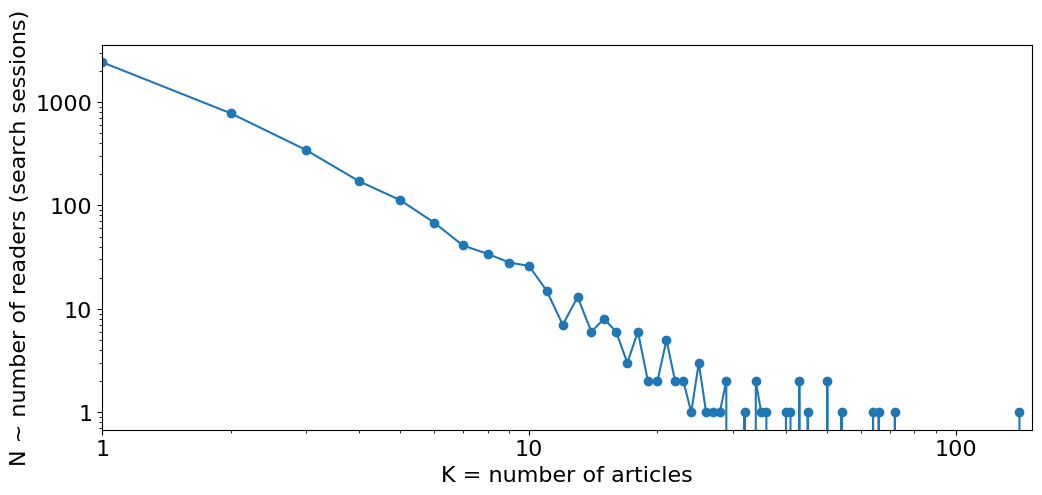

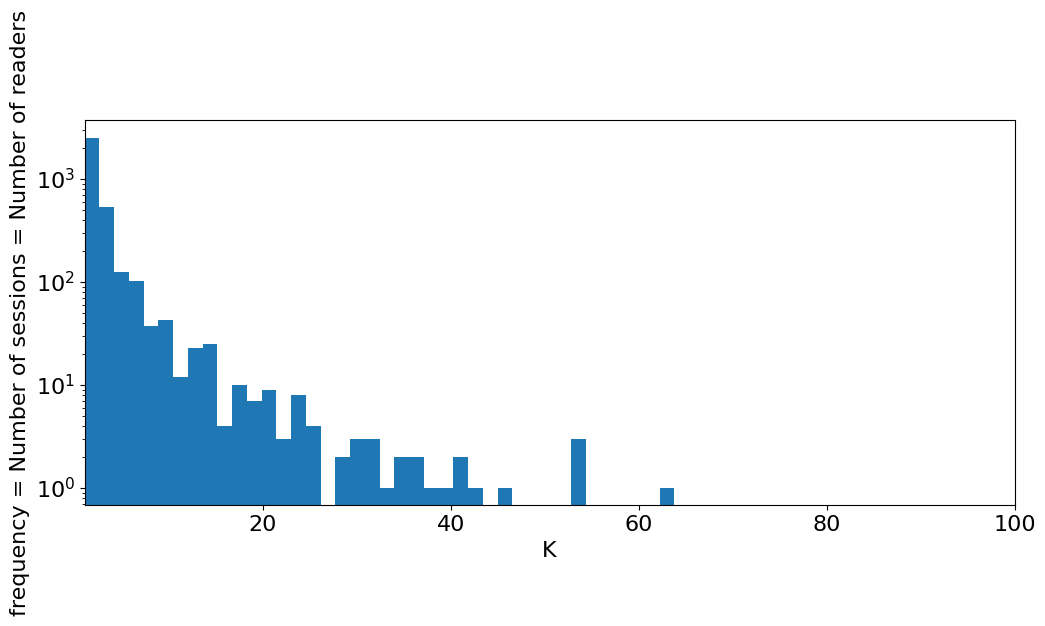

K max =  158


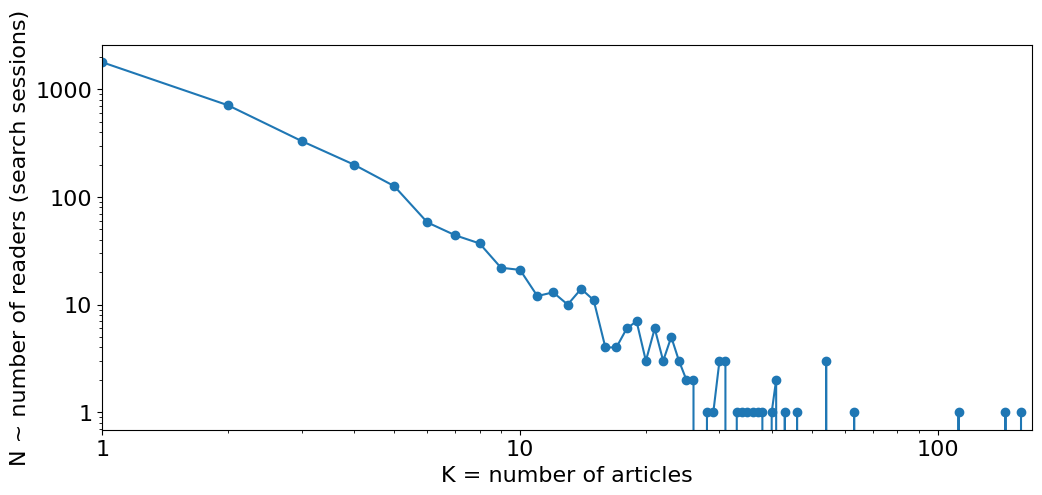

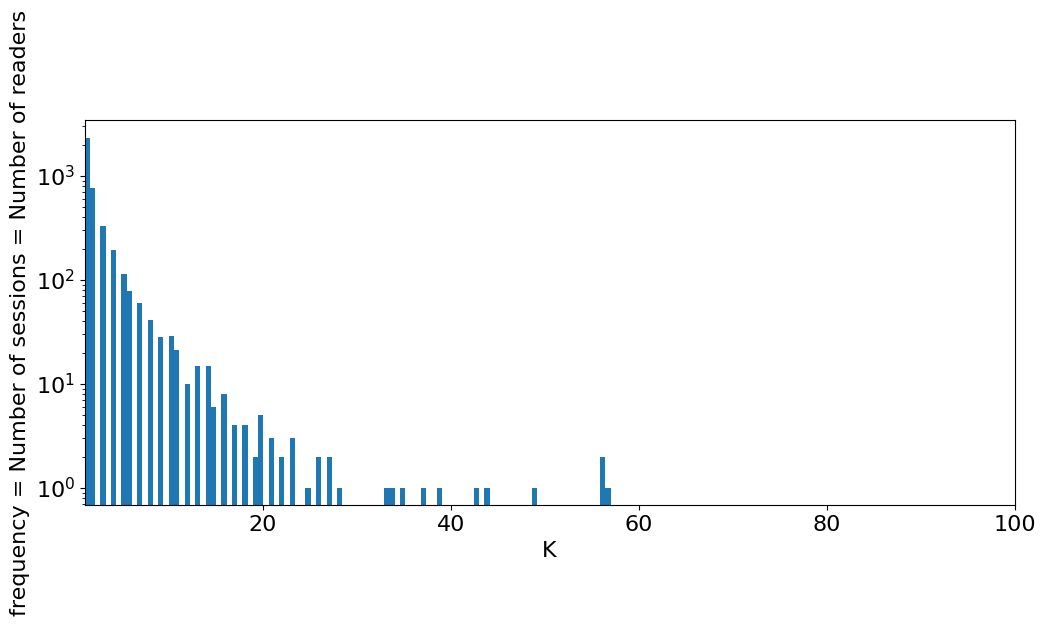

K max =  57


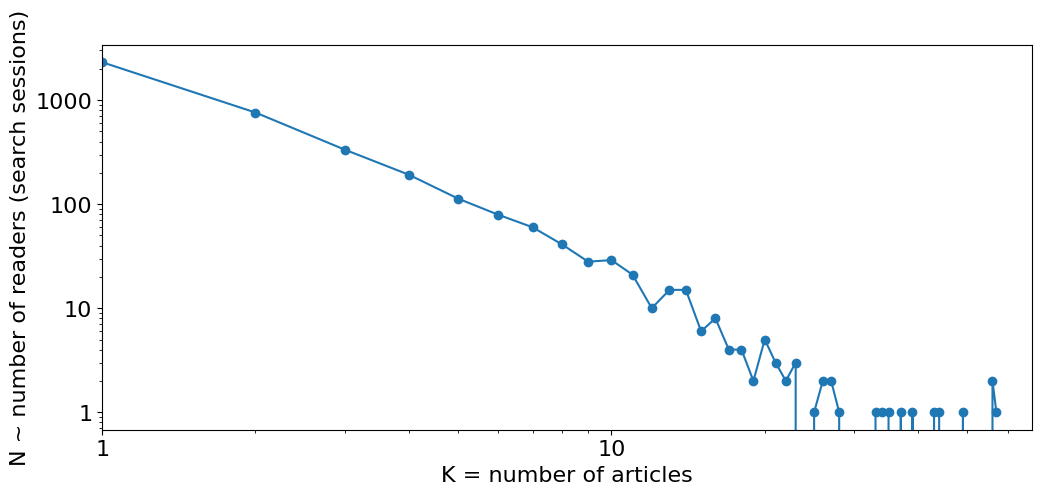

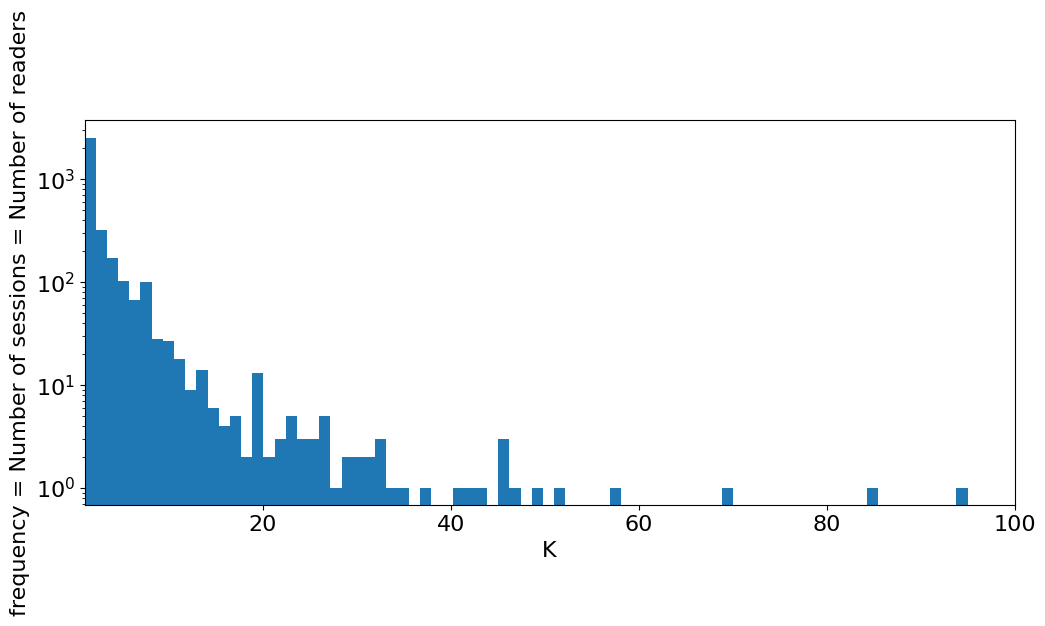

K max =  120


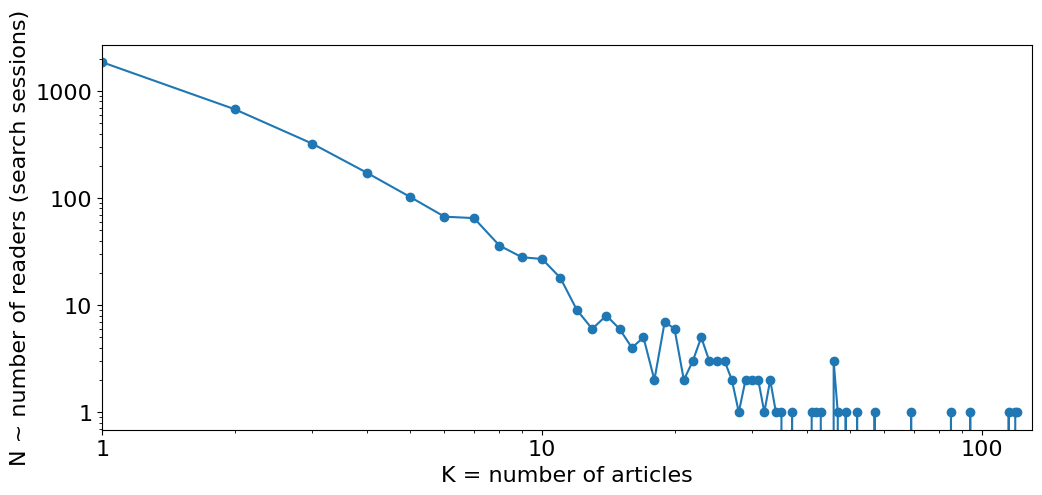

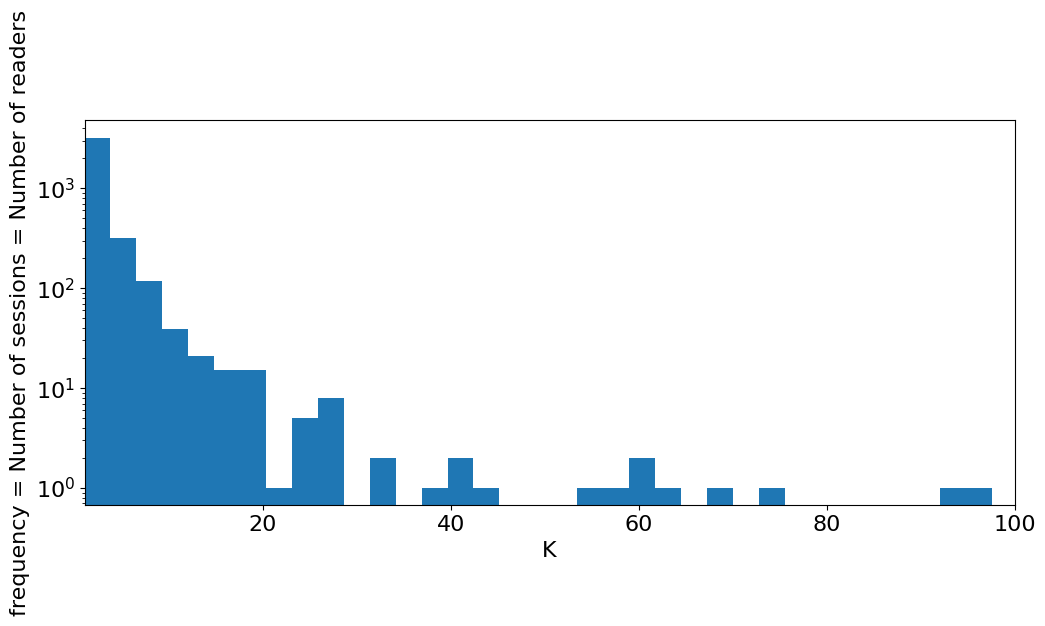

K max =  277


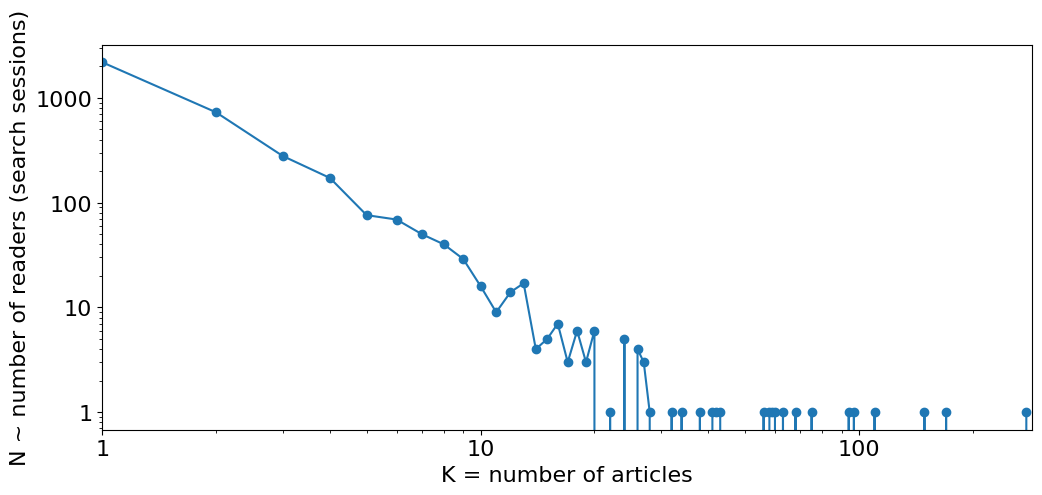

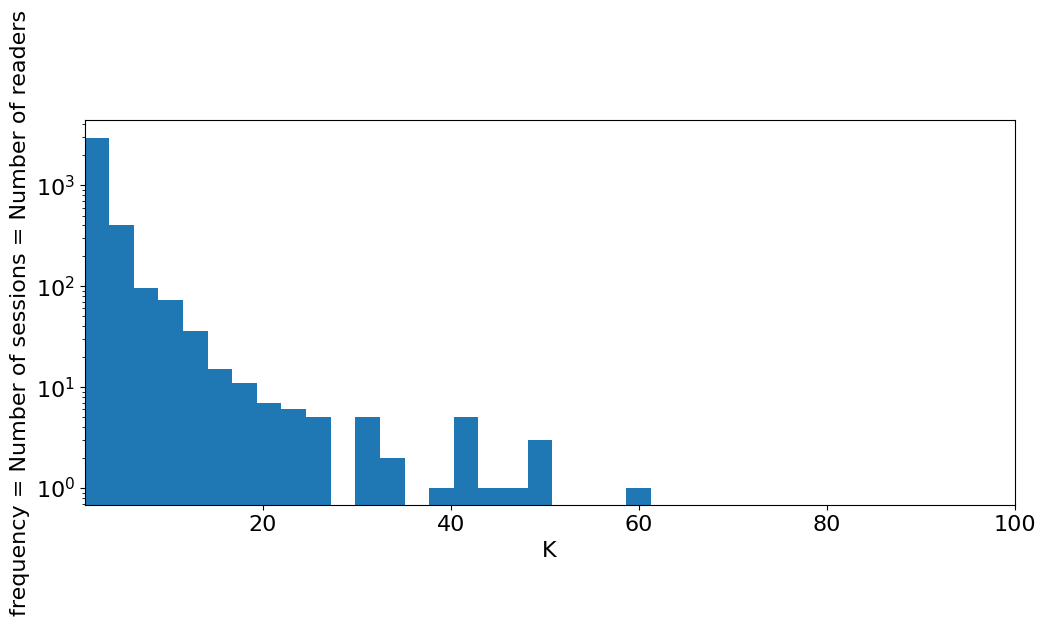

K max =  263


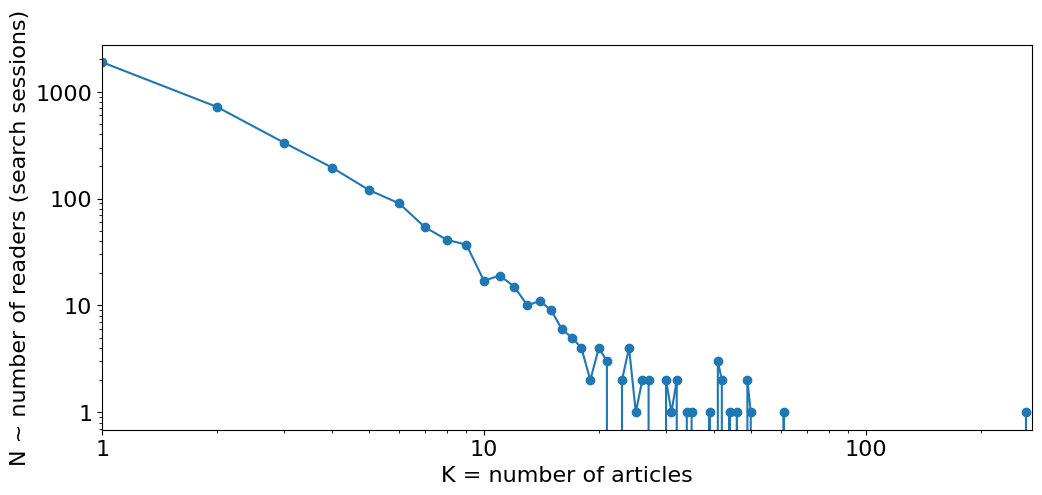

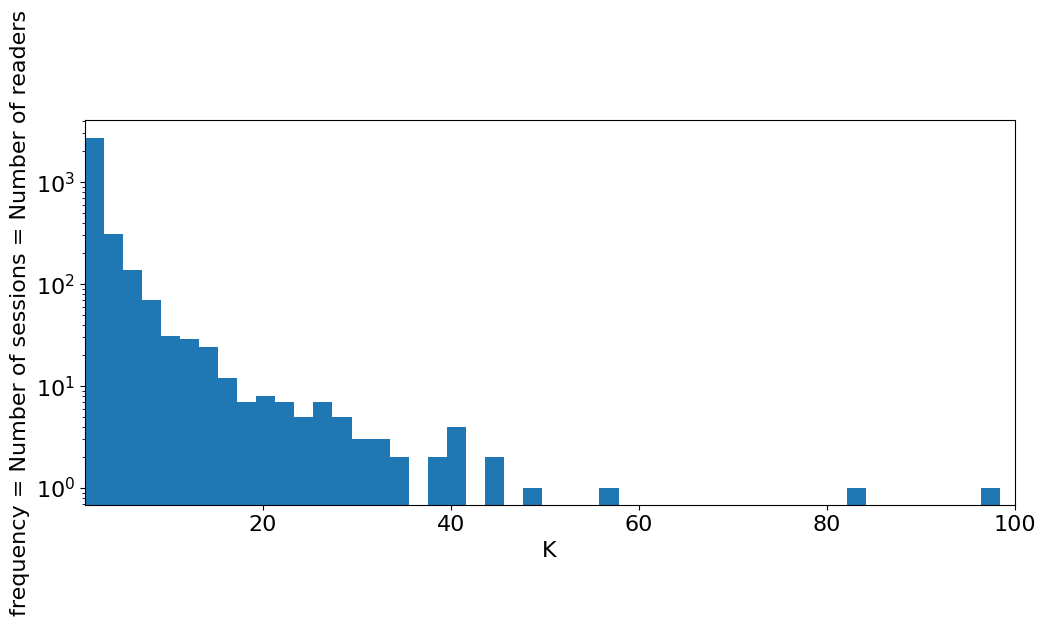

K max =  204


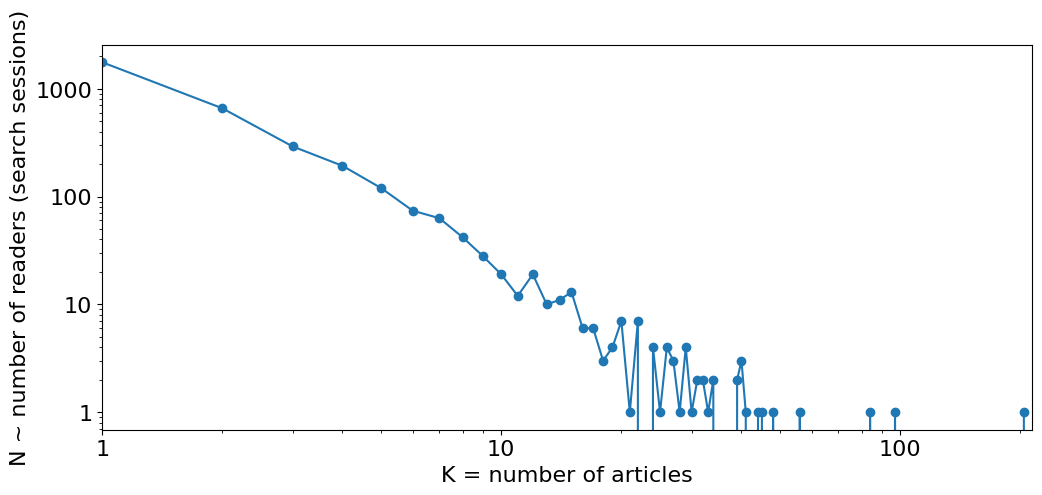

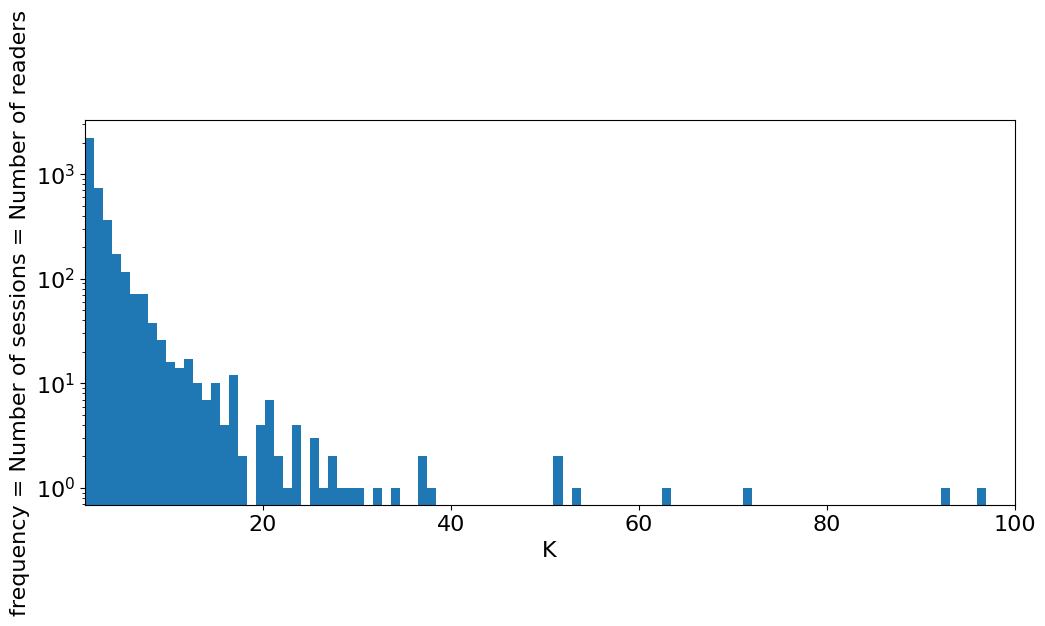

K max =  97


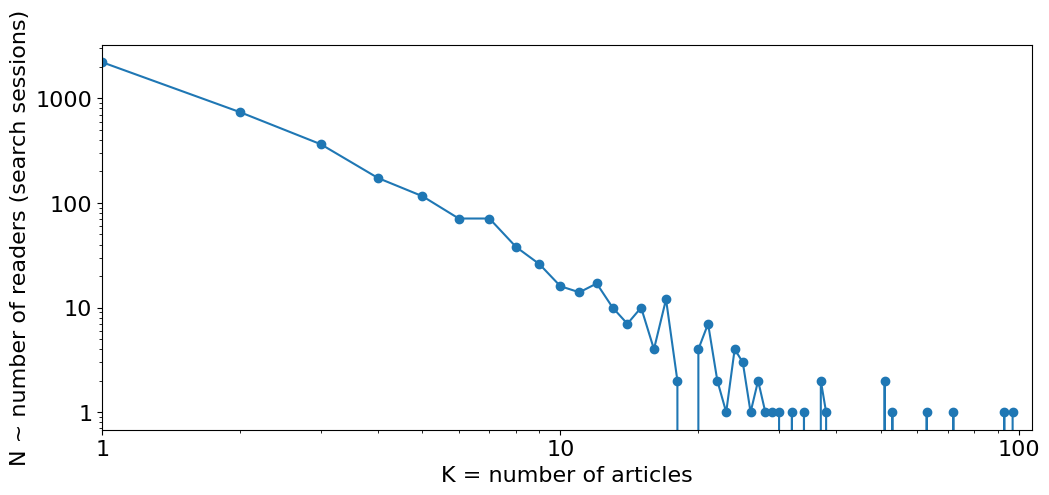

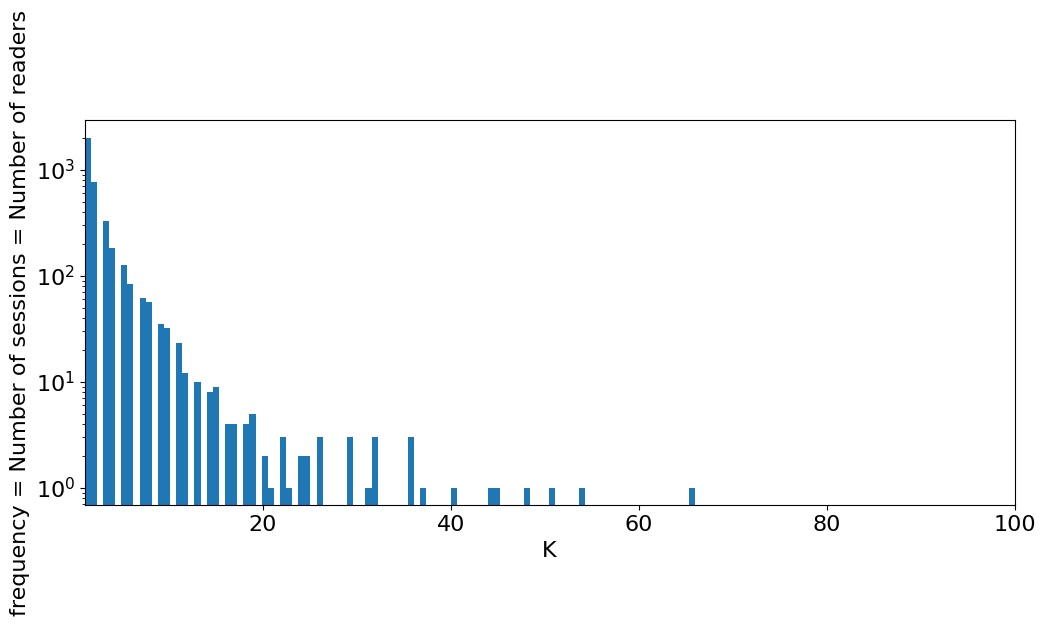

K max =  66


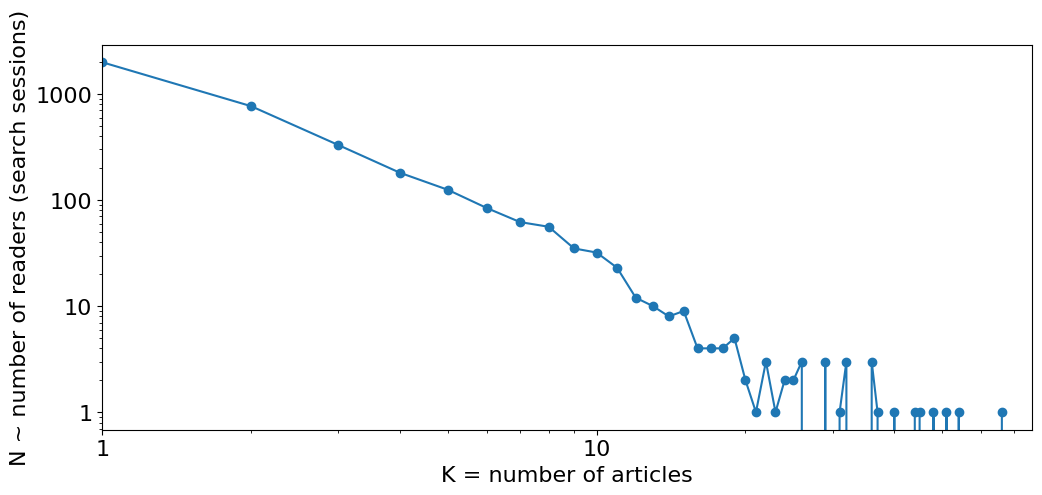

In [15]:
# Affichage des graphes des valeurs de N et K
def afficheK(K):
    fig, ax = plt.subplots(figsize=(12,5))
    plt.rcParams['font.size'] = '16'
    ax.hist(K, bins=100, log=True)
    ax.set_xlim(1,100)
    ax.set_xlabel('K')
    ax.set_ylabel('frequency = Number of sessions = Number of readers')
    plt.show()

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

def afficheNK(N,K):
    fig, ax = plt.subplots(figsize=(12,5))
    plt.rcParams['font.size'] = '16'
    ax.plot(N, marker="o")
    ax.set_xlim(1,np.max(K)+10)
    #ax.set_xticks(np.arange(0,101,10))
    ax.set_xlabel('K = number of articles')
    ax.set_ylabel('N ~ number of readers (search sessions)')
    #ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.get_xaxis().get_major_formatter().labelOnlyBase = False
    print("K max = ", np.max(K))
    plt.show()

indiceBloc=0
for i in range(100):
    if i % 5 == 0 :
        afficheK(K[indiceBloc])
        afficheNK(N[indiceBloc],K[indiceBloc])
    indiceBloc +=1

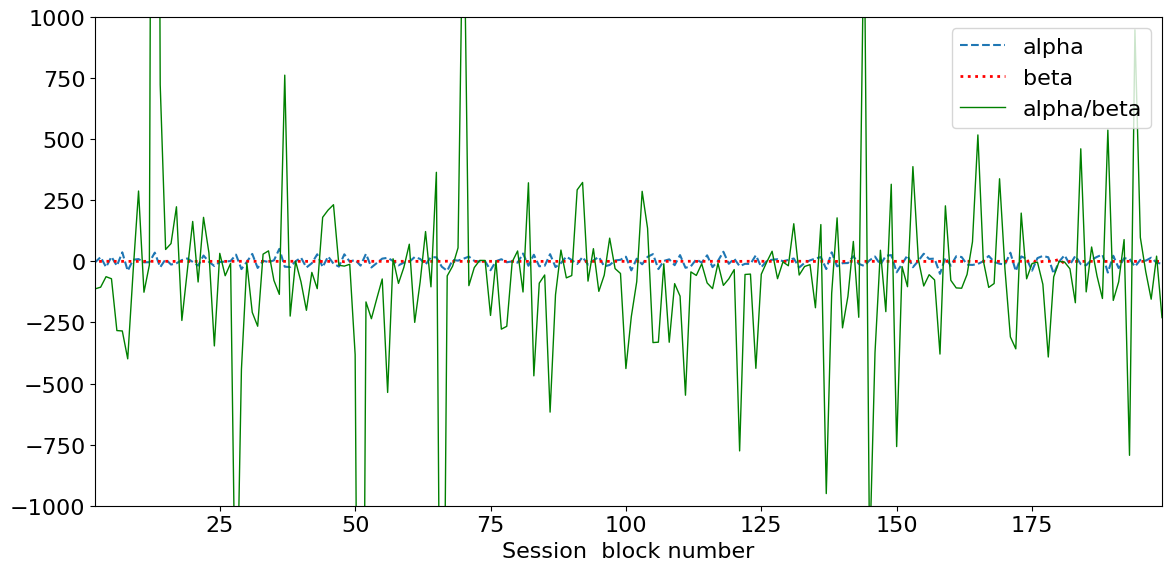

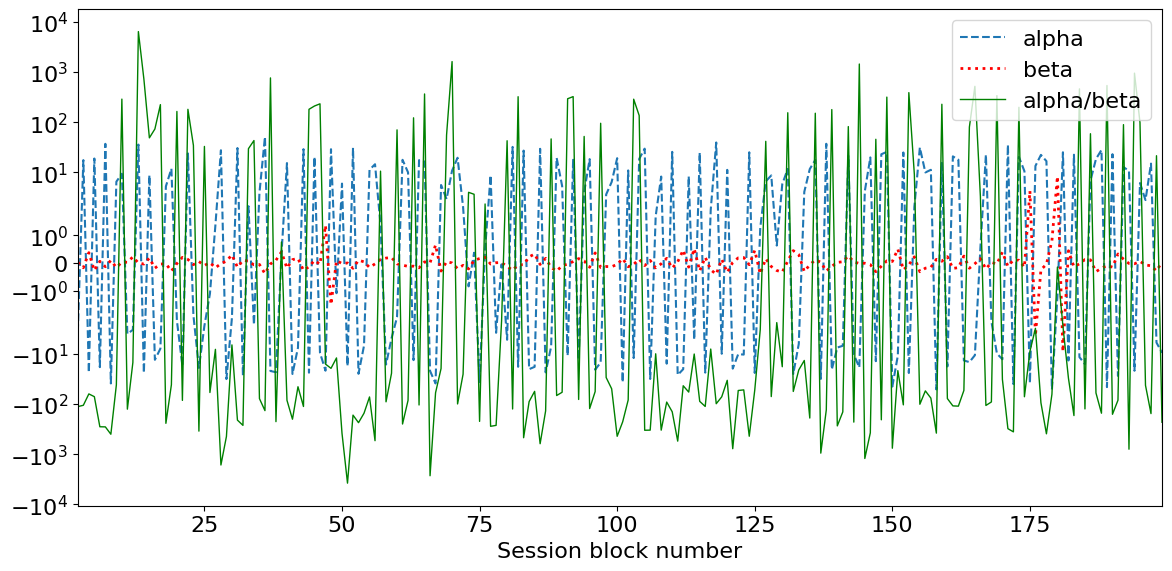

In [70]:
#Calcul des alpha et béta et de leur rapport
#affichage
lastBloc = 200
firstBloc = 1

alpha = [0 for _ in range(len(blocs))]
beta =  [0 for _ in range(len(blocs))]
ratio =  [0 for _ in range(len(blocs))]
for i in range(1,len(blocs)):
    #alpha[i] = math.log(math.fabs(NMean[i] - NMean[i-1])+1)
    alpha[i] = NMean[i] - NMean[i-1]
    #beta[i] = math.log(math.fabs(KMean[i] - KMean[i-1])+1)
    beta[i] = KMean[i] - KMean[i-1]
    if beta[i] != 0 :
        ratio[i] = alpha[i]/beta[i]
    else:
        ratio[i] = math.inf
#print("valeurs de alpha :", alpha)
#print("valeurs de beta : ", beta)

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
#plt.xlim(2,len(blocs)-1)
plt.xlim(firstBloc+1,lastBloc-1)
plt.xlabel('Session  block number')
plt.ylim(-1000,1000)
plt.plot(alpha, linestyle='--', label='alpha')
plt.plot(beta, linestyle=':', color='r', label='beta',linewidth=2)
plt.plot(ratio, color='g', label='alpha/beta',linewidth=1)
plt.legend(loc='upper right')
plt.show()
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
#plt.xlim(2,len(blocs)-1)
plt.xlim(firstBloc+1,lastBloc-1)
plt.xlabel('Session block number')
plt.plot(alpha, linestyle='--', label='alpha')
plt.plot(beta, linestyle=':', color='r', label='beta', linewidth=2)
plt.plot(ratio, color='g', label='alpha/beta', linewidth=1)
plt.legend(loc='upper right')
plt.yscale('symlog')
plt.show()

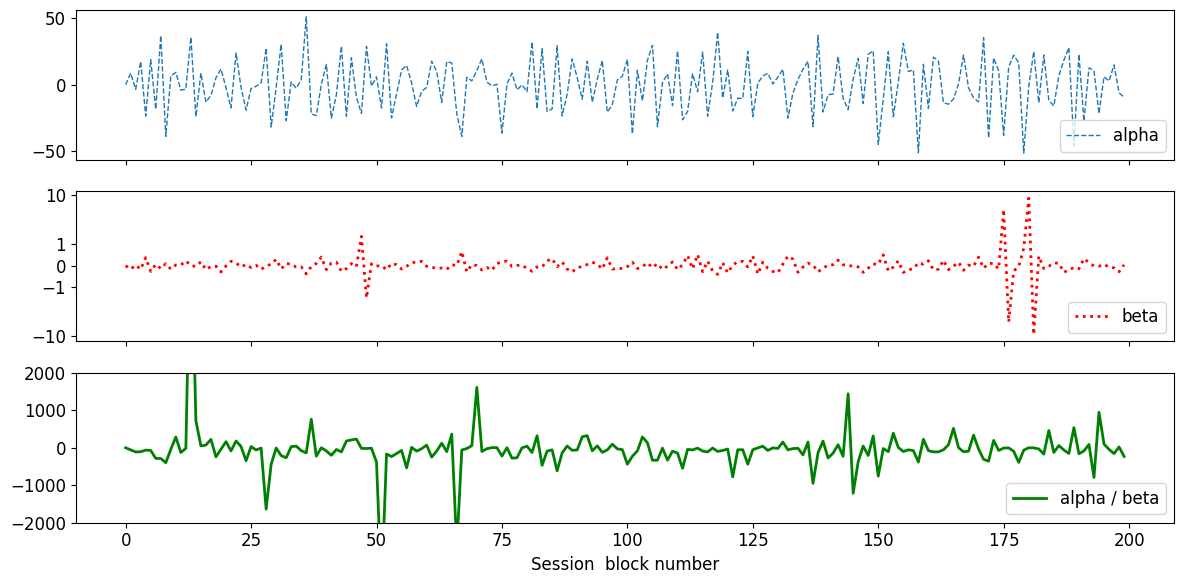

In [108]:
import matplotlib.ticker as ticker

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '12'
ax1 = plt.subplot(311)
ax1.plot(alpha, linestyle='--', label='alpha', linewidth=1)
#ax1.set_yscale('symlog')
ax1.legend(loc='lower right')
plt.tick_params('x', labelbottom=False)
ax2=plt.subplot(312)
#ax2.set_ylabel('alpha and beta values')
ax2.plot(beta, linestyle=':', color='r', label='beta',linewidth=2)
ax2.set_yscale('symlog')
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter())
#ax2.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.8f"))
ax2.yaxis.set_minor_formatter(ticker.ScalarFormatter())
#ax2.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.8f"))
#ax2.ylim(-1000,1000)
ax2.legend(loc='lower right')
plt.tick_params('x', labelbottom=False)
ax3=plt.subplot(313)
#ax3.set_ylabel('(alpha ÷ beta) values')
ax3.plot(ratio, color='g', label='alpha / beta',linewidth=2)
ax3.set_ybound(-2000,2000)
ax3.set_xlabel('Session  block number')
ax3.legend(loc='lower right')
plt.show()

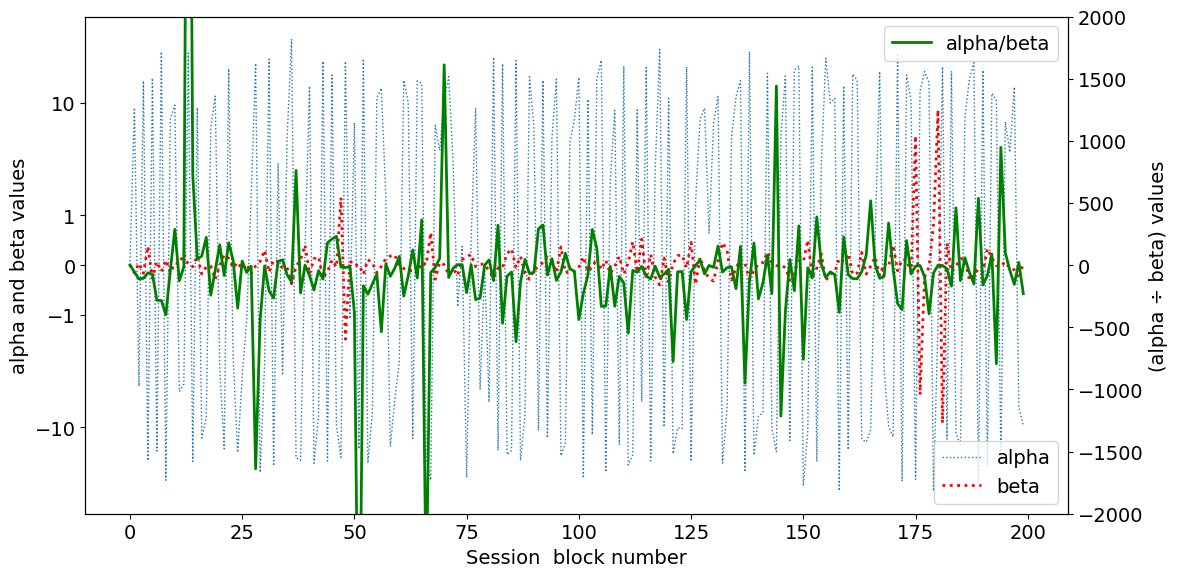

In [107]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel('Session  block number')
ax1.set_ylabel('alpha and beta values')
ax1.plot(alpha, linestyle=':', label='alpha', linewidth=1)
ax1.plot(beta, linestyle=':', color='r', label='beta',linewidth=2)
ax1.set_yscale('symlog')
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.legend(loc='lower right')
ax2=ax1.twinx()
ax2.set_ylabel('(alpha ÷ beta) values')
ax2.plot(ratio, color='g', label='alpha/beta',linewidth=2)
ax2.set_ybound(-2000,2000)
ax2.legend(loc='upper right')
plt.show()


In [127]:
#Attribution des types pour chaque bloc de sessions
typeBlocSession = ['NA' for _ in range(len(blocs))]
coeff = 0.5
Nmax = np.max(NMean) - abs(np.max(NMean)-np.min(NMean))*coeff
Nmin = np.min(NMean) + abs(np.max(NMean)-np.min(NMean))*coeff
Kmax = np.max(KMean) - abs(np.max(NMean)-np.min(NMean))*coeff
KMin = np.min(KMean) + abs(np.max(NMean)-np.min(NMean))*coeff
#print("MAX: ", np.max(ratio))
ratioMax = 80
ratio1 = 10
print ("Nmax = {} Nmin = {} KMax = {} KMin = {}, ratioMax = {}".format(Nmax,Nmin,Kmax,KMin, ratioMax))
print("Nombre blocs de sessions :", len(blocs))
for i in range(1, len(blocs)):
    #print (NMean[i], KMean[i], ratio[i])
    if NMean[i]>Nmax and KMean[i]>Kmax and abs(ratio[i])>ratioMax:
        typeBlocSession[i]='a'
    elif NMean[i]<Nmin and KMean[i]>Kmax and abs(ratio[i])<ratio1:
        typeBlocSession[i]='b'
    elif NMean[i]<Nmin and KMean[i]<KMin and abs(ratio[i])>ratioMax:
        typeBlocSession[i]='c'
    elif NMean[i]<Nmin and KMean[i]<KMin and abs(ratio[i])<ratio1:
        typeBlocSession[i]='d'
    elif NMean[i]>Nmax and KMean[i]<KMin and abs(ratio[i])>ratioMax:
        typeBlocSession[i]='e'
    elif NMean[i]>Nmax and KMean[i]>Kmax and abs(ratio[i])<ratio1:
        typeBlocSession[i]='f'
typesNb = Counter(typeBlocSession)
print(typesNb)

Nmax = 36.24904776350827 Nmin = 36.24904776350828 KMax = -29.796175299004737 KMin = 36.21135725636343, ratioMax = 80
Nombre blocs de sessions : 100
Counter({'NA': 36, 'c': 34, 'a': 23, 'b': 5, 'f': 2})


('f', 'f', {'weight': 7.639433157539186})
('f', 'c', {'weight': -217.61599623940452})
('c', 'a', {'weight': 242.03713549815285})
('c', 'c', {'weight': -543.186671311727})
('c', 'b', {'weight': -267.9150166172207})
('b', 'a', {'weight': -83.2439467089139})
('a', 'a', {'weight': -2317.8749823903922})


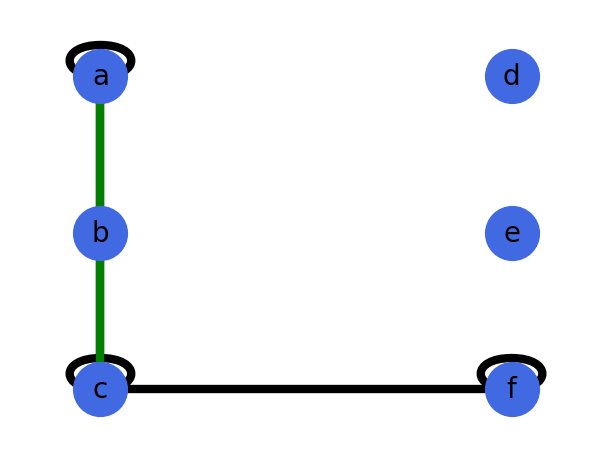

In [128]:
# affichage du graphe
'''Functions to enumerate all perfect and maximum matchings in bipartited graph.

NOTICE: We would like to develop a bipartite graph that can be placed in our paper.


Author: Otmane Azeroual
Update time: 2020-12-11 18:41:56.
'''



#--------Import modules-------------------------
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from networkx.algorithms import bipartite
from networkx.algorithms.bipartite import hopcroft_karp_matching

data = pd.DataFrame(
    {'domain': ["c", "b", "a"],
     'subdomain': ["f", "e", "d"]})

B = nx.Graph()
B.add_nodes_from(data['subdomain'], bipartite=0)
B.add_nodes_from(data['domain'], bipartite=1)

''' :::::::::::::::::::'''
''' Ajout P. Bellot pour récupérer les types de session identifiés '''
for i in range(0, len(blocs)-1):
    if typeBlocSession[i] != 'NA' and typeBlocSession[i+1] != 'NA':
        B.add_edge(typeBlocSession[i], typeBlocSession[i+1], weight=ratio[i]+ratio[i+1])
''' :::::::::::::::::::'''

edge_to_count = dict()
for edge in B.edges():
    try:
        edge_to_count[edge] += 1
    except KeyError:
        edge_to_count[edge] = 1

pos = nx.spring_layout(B)

for edge in B.edges(data=True): print(edge)

elarge = [(u, v) for (u, v, d) in B.edges(data=True) if d["weight"] <= 12] #black
exlarge = [(u, v) for (u, v, d) in B.edges(data=True) if d["weight"] > 12 and d["weight"] < 33] #red
esmall = [(u, v) for (u, v, d) in B.edges(data=True) if d["weight"] >= 33] #green

pos = {node:[0, i] for i,node in enumerate(data['domain'])}
pos.update({node:[1, i] for i,node in enumerate(data['subdomain'])})

nx.draw_networkx_edge_labels(B, pos, edge_to_count, label_pos=1)

#nx.draw_networkx_nodes(B, pos, node_size=1500, node_color="royalblue", with_labels=False)
nx.draw_networkx_nodes(B, pos, node_size=1500, node_color="royalblue")

nx.draw_networkx_edges(B, pos, edgelist=elarge, width=6)

nx.draw_networkx_edges(B, pos, edgelist=exlarge, width=6, edge_color="r", style="solid")
nx.draw_networkx_edges(B, pos, edgelist=esmall, width=6, edge_color="g", style="solid")

nx.draw_networkx_labels(B, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.tight_layout()
plt.show()

#

In [34]:
# =======================================================================================
# !!! Expérience qui  ne correspond pas aux définitions de N et K finalement retenues
# =======================================================================================

# Estimation des valeurs de N et K pour chaque article lu, a posteriori
# N désigne le nombre de lecteurs qui ont lu l'article
# K désigne un nombre d'articles proposés au lecteur. Ici K est défini de manière aléatoire
num_session = -1
import random
indice_N_sessions = [[] for _ in range(nombre_sessions_graphe)]
indice_K_sessions = [[] for _ in range(nombre_sessions_graphe)]
for ind in data.index:
    url_lue = data['id_url'][ind]
    num_step = data['num_step_in_session'][ind] - 1
    if data['num_step_in_session'][ind] > 1:
        if data['num_step_in_session'][ind] == 2:
            num_session += 1
            sigma = random.randint(1,50)
            mu = random.randint(1,500)
            #print("session ", num_session, " num_step : ", data['num_step_in_session'][ind], " ajout de : ", [graph.nodes[url_precedente]['nb']], " pour l'URL précédente : ", url_precedente)
            indice_N_sessions[num_session].append(graph.nodes[url_precedente]['nb'])
            indice_K_sessions[num_session].append(int(abs(random.gauss(mu,sigma))))
        #print("session ", num_session, " num_step : ", data['num_step_in_session'][ind], " ajout de : ", [graph.nodes[url_lue]['nb']], " pour l'URL : ", url_lue)
        indice_N_sessions[num_session].append(graph.nodes[url_lue]['nb'])
        indice_K_sessions[num_session].append(int(abs(random.gauss(mu,sigma))))
    url_precedente = url_lue
print(indice_N_sessions)
print(indice_K_sessions)


KeyError: 'id_url'